In [1]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss, matthews_corrcoef, precision_recall_curve, auc
import pickle
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import datetime
from collections import defaultdict, Counter

import sys
sys.path.append('../../')

# utils
from common_utils.logger import init_logger
from common_utils.settings import cfg_init
from common_utils.kf import get_fold
# from common_utils.gbdt.model_gbdt import LightGBM, CatBoost
# from common_utils.gbdt.model_gbdt import LightGBM
from common_utils.feature_engineering.base import run_block, NumericBlock, LabelEncodingBlock, CountEncodingBlock, AggBlock, TargetEncodingBlock
from common_utils.feature_engineering.text import TextLenBlock, TfidfSVDBlock

/home/ryosuke/.cache/pypoetry/virtualenvs/kaggle-pipeline-atmacup-16-kgwzrA72-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from myutils.metrics import mapk

In [3]:
from common_utils.metrics import calc_auc_score

In [4]:
class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_16'

    comp_dir_path = '../../'
    comp_folder_name = 'atmaCup16_Dataset'  # compのデータセットのフォルダ名
    comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'

    try:
        exp_name = os.path.basename(__file__).split('.')[0]
    except Exception:
        print('running kernel')
        exp_name = None
    
    exp_name = 'train_gbdt_2stage_feature_only_sep_train_test_exp002' # notebook

    # ============== model =============
    model_name = 'lgb_gkf'

    # ============== features =============
    catboost_cat_cols = []
    catboost_text_cols = []
    top_k = 40
    # ============== pred target =============
    # target_col = 'target'
    target_col = 'target_multi'

    target_size = 1
    num_class = 5 # multiclassの場合

    # ============== fold =============
    n_fold = 5
    skf_col = 'session_id'
    group_col = 'session_id'
    fold_type = 'gkf'

    objective_cv = 'binary'  # collateとかの型を決める用
    metric_direction = 'maximize'  # gbdtだと使わない
    metrics = 'calc_auc_score'

    # ============== wandb =============
    wandb_note = f'starter'

    # ============== ほぼ固定 =============
    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = comp_dir_path +  \
            f'outputs/{comp_name}/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

running kernel
set dataset path


## trainとtestで別の特徴量

In [5]:
sep_train_test_cols = []

## todo 

last_itemと同じ候補は取り除く

In [6]:
warnings.filterwarnings('ignore')

cfg_init(CFG)

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2023年12月17日 13:58:52


In [7]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import pandas as pd
import matplotlib.pyplot as plt
import pickle


class LightGBM:

    def __init__(self, lgb_params, save_dir=None, imp_dir=None, categorical_feature=None,
                 model_name='lgb',
                 stopping_rounds=50) -> None:
        self.save_dir = save_dir
        self.imp_dir = imp_dir
        self.lgb_params = lgb_params
        self.categorical_feature = categorical_feature

        # saveの切り替え用
        self.model_name = model_name

        self.stopping_rounds = stopping_rounds

    def fit(self, x_train, y_train, train_group, val_group, **fit_params) -> None:

        X_val, y_val = fit_params['eval_set'][0]
        del fit_params['eval_set']

        train_dataset = lgb.Dataset(
            x_train, y_train, group=train_group, categorical_feature=self.categorical_feature)

        val_dataset = lgb.Dataset(
            X_val, y_val, group=val_group, categorical_feature=self.categorical_feature)

        self.model = lgb.train(params=self.lgb_params,
                               train_set=train_dataset,
                               valid_sets=[train_dataset, val_dataset],
                               callbacks=[lgb.early_stopping(stopping_rounds=self.stopping_rounds,
                                                             verbose=True),
                                          lgb.log_evaluation(50)],
                               **fit_params
                               )

    def plot_importance(self, fold):
        gain_importances = pd.DataFrame({'Feature': self.model.feature_name(),
                                         'Importance': self.model.feature_importance(importance_type='gain')})

        gain_importances.to_csv(
            f'{self.imp_dir}lgb_imp_fold_{fold}_{self.model_name}.csv', index=False)

        gain_importances = gain_importances.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)

        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        # plt.ylabel('Feature', fontsize=12)
        plt.title(f'gain importance fold {fold}')
        plt.savefig(
            f'{self.imp_dir}gain_importance_fold{fold}_{self.model_name}.png', bbox_inches='tight')

    def plot_importance_all(self, n_fold=5):
        dfs = [pd.read_csv(
            f'{self.imp_dir}lgb_imp_fold_{fold}_{self.model_name}.csv') for fold in range(n_fold)]
        imp_df = pd.concat(dfs).reset_index(drop=True)
        imp_df = imp_df.groupby(['Feature'])['Importance'].mean().reset_index()

        gain_importances = imp_df.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        plt.title('gain importance all')
        plt.savefig(
            f'{self.imp_dir}gain_importance_all_{self.model_name}.png', bbox_inches='tight')

        return imp_df

    def save(self, fold):
        save_to = f'{self.save_dir}lgb_fold_{fold}_{self.model_name}.txt'
        self.model.save_model(save_to)

    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)

In [8]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import catboost
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class CatBoost:

    def __init__(self, lgb_params, mode, save_dir=None, imp_dir=None, categorical_feature=None, text_features=None,
                 model_name='catboost') -> None:
        self.mode = mode
        self.save_dir = save_dir
        self.imp_dir = imp_dir
        self.lgb_params = lgb_params
        self.categorical_feature = categorical_feature
        self.text_features = text_features

        # saveの切り替え用
        self.model_name = model_name

    def fit(self, x_train, y_train, train_group, val_group, **fit_params) -> None:

        print('categorical feature')
        print(self.categorical_feature)

        print('text feature')
        print(self.text_features)

        X_val, y_val = fit_params['eval_set'][0]
        del fit_params['eval_set']

        train_pool = Pool(x_train, y_train, text_features=self.text_features,
                          cat_features=self.categorical_feature,
                          group_id=train_group)
        val_pool = Pool(X_val, y_val, text_features=self.text_features,
                        cat_features=self.categorical_feature,
                        group_id=val_group)

        """
        if self.mode == 'regression':
            self.model = CatBoostRegressor(**self.lgb_params)
        else:
            self.model = CatBoostClassifier(**self.lgb_params)
        """
        self.model = catboost.CatBoost(self.lgb_params)        

        self.model.fit(train_pool,
                       eval_set=val_pool,
                       **fit_params
                       )
        self.gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                              'Importance': self.model.get_feature_importance(train_pool)})


    def plot_importance(self, fold):
        """
        gain_importances = pd.DataFrame({'Feature': self.model.feature_names_,
                                         'Importance': self.model.feature_importances_})
        """
        # rerankerだとNoneになる
        # print(self.model.feature_importances_)
        gain_importances = self.gain_importances

        gain_importances.to_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv', index=False)

        gain_importances = gain_importances.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)

        # plt.ylabel('Feature', fontsize=12)
        plt.title(f'gain importance fold {fold}')
        plt.savefig(
            f'{self.imp_dir}gain_importance_fold{fold}_{self.model_name}.png', bbox_inches='tight')

    def plot_importance_all(self, n_fold=5):
        dfs = [pd.read_csv(
            f'{self.imp_dir}catboost_imp_fold_{fold}_{self.model_name}.csv') for fold in range(n_fold)]
        imp_df = pd.concat(dfs).reset_index(drop=True)
        imp_df = imp_df.groupby(['Feature'])['Importance'].mean().reset_index()

        gain_importances = imp_df.nlargest(
            50, 'Importance', keep='first').sort_values(by='Importance', ascending=True)
        gain_importances[['Importance', 'Feature']].plot(
            kind='barh', x='Feature', color='blue', figsize=(12, 8), fontsize=9)
        plt.title('gain importance all')
        plt.savefig(
            f'{self.imp_dir}gain_importance_all_{self.model_name}.png', bbox_inches='tight')

        return imp_df
    
    def save(self, fold):
        save_to = f'{self.save_dir}catboost_fold_{fold}_{self.model_name}.pkl'
        pickle.dump(self.model, open(save_to, 'wb'))
        
    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self, x):
        return self.model.predict_proba(x)
        # return self.model.predict(x, prediction_type='Probability')[:, 1]


In [9]:
def get_model(model_name):
    if 'lgb' in model_name:
        """
        適宜追加: 
        'metric': 'rmse',
        """
        """
        lgb_params = {'objective': CFG.objective_cv, 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.1,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    'metric': 'auc',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    }
        """

        lgb_params = {'objective': 'lambdarank', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 'learning_rate': 0.1,
                    # 'num_class': CFG.num_class, # multiclassなら必要
                    # 'metric': 'map',
                    'num_leaves': 64,
                    'max_depth': 5,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }
        
        """
        lgb_params = {'objective': 'xendcg', 'boosting_type': 'gbdt', 'verbose': -1,
                    'n_jobs': 8, 'seed': CFG.seed, 
                    'learning_rate': 0.1,
                    # 'num_leaves': 255,
                    # 'min_data_in_leaf': 100,
                    'bagging_seed': CFG.seed,
                    'feature_fraction_seed': CFG.seed,
                    'drop_seed': CFG.seed,
                    # "eval_at": 10,
                    }
        """
        model = LightGBM(lgb_params=lgb_params,
                        imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                        model_name=model_name)
    elif 'catboost' in model_name:
        """
        追加予定: 
        'loss_function': 'RMSE', 'task_type': 'GPU',
        """
        lgb_params = {
                    # 'random_seed': CFG.seed, 
                    'iterations': 10000,
                    'loss_function': 'YetiRank',
                    # 'loss_function': 'PairLogitPairwise',
                    'task_type': 'GPU',
                    # 'learning_rate': 0.01,
                    "random_state": 42,
                    }
        if lgb_params['loss_function'] == 'PairLogitPairwise':
            lgb_params['learning_rate'] = 0.05
            lgb_params['iterations'] = 100000

        model = CatBoost(lgb_params=lgb_params,
                         mode = CFG.objective_cv,
                         imp_dir=CFG.figures_dir, save_dir=CFG.model_dir,
                         model_name=model_name,
                         categorical_feature=CFG.catboost_cat_cols,
                         text_features=CFG.catboost_text_cols)       


    return model

In [10]:
def get_fit_params(model_name):
    if 'lgb' in model_name:
        params = {
            'num_boost_round': 100000
        }
        # 'stopping_rounds': 50, # 'early_stopping_rounds': 50,
        #         'verbose_eval': 50
    elif 'catboost' in model_name:
        params = {
            'early_stopping_rounds': 50,
            'verbose': 50,
            'use_best_model': True,
        }
        
    return params

In [11]:
def get_result(result_df):

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values

    eval_func = eval(CFG.metrics)
    best_score = eval_func(labels, preds)

    Logger.info(f'best_score: {best_score:<.4f}')
    return best_score


In [12]:
train_log_df = pd.read_csv(CFG.comp_dataset_path + 'train_log.csv')
train_label_df = pd.read_csv(CFG.comp_dataset_path + 'train_label.csv')
test_log_df = pd.read_csv(CFG.comp_dataset_path + 'test_log.csv')
yado_df = pd.read_csv(CFG.comp_dataset_path + 'yado.csv')

train_session_only_df = train_label_df[['session_id']]
test_session_only_df = pd.read_csv(CFG.comp_dataset_path + 'test_session.csv')

train_test_log_df = pd.concat([train_log_df, test_log_df], axis=0).reset_index(drop=True)

In [13]:
"""
test_session_to_num_dict = dict([(s, i) for i, s in enumerate(test_session_only_df['session_id'].values)])
test_log_df['session_id_num'] = test_log_df['session_id'].map(test_session_to_num_dict)

test_log_df['ori_idx'] = test_log_df.index
test_log_df = test_log_df.sort_values(['session_id_num', 'seq_no'], ascending=[True, True]).reset_index(drop=True)
(test_log_df.index == test_log_df['ori_idx']).sum()/len(test_log_df)
"""

"\ntest_session_to_num_dict = dict([(s, i) for i, s in enumerate(test_session_only_df['session_id'].values)])\ntest_log_df['session_id_num'] = test_log_df['session_id'].map(test_session_to_num_dict)\n\ntest_log_df['ori_idx'] = test_log_df.index\ntest_log_df = test_log_df.sort_values(['session_id_num', 'seq_no'], ascending=[True, True]).reset_index(drop=True)\n(test_log_df.index == test_log_df['ori_idx']).sum()/len(test_log_df)\n"

In [14]:
test_log_df

,session_id,seq_no,yad_no
0,00001149e9c73985425197104712478c,0,3560
1,00001149e9c73985425197104712478c,1,1959
2,0000e02747d749a52b7736dfa751e258,0,11984
3,0000f17ae2628237d78d3a38b009d3be,0,757
4,0000f17ae2628237d78d3a38b009d3be,1,8922
...,...,...,...
250300,fffee3199ef94b92283239cd5e3534fa,1,8336
250301,ffff62c6bb49bc9c0fbcf08494a4869c,0,12062
250302,ffff9a7dcc892875c7a8b821fa436228,0,8989
250303,ffffb1d30300fe17f661941fd085b04b,0,6030


## yado fillna

In [15]:
fillna_cols = ['wireless_lan_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min']

yado_df[fillna_cols] = yado_df[fillna_cols].fillna(0).astype(np.int8)

In [16]:
print(yado_df.dtypes)

yad_no                 int64
yad_type               int64
total_room_cnt       float64
wireless_lan_flg        int8
onsen_flg              int64
kd_stn_5min             int8
kd_bch_5min             int8
kd_slp_5min             int8
kd_conv_walk_5min       int8
wid_cd                object
ken_cd                object
lrg_cd                object
sml_cd                object
dtype: object


In [17]:
# candidate_names = ['past_item', 'next_view_item', 'same_area_sml_cd']
candidate_names = ['past_item', 'next_view_item_cand_50', 'same_area_lrg_cd']
candidate_rank_cols = ['rank_past_item']

In [18]:
def make_train_test_df(mode: str) -> pd.DataFrame:
    output_df = pd.DataFrame()
    candidate_rank_cols = []

    for candidate_name in candidate_names:
        session_df = pd.read_pickle(f'../../datasets/candidate_df/{candidate_name}_{mode}.pkl')
        # print(session_df['yad_no'].isnull().sum())
        session_df['yad_no'] = session_df['yad_no'].astype(int)

        if candidate_name == 'past_item':
            session_df.rename(columns={'rank': f'rank_{candidate_name}'}, inplace=True)
            candidate_rank_cols.append(f'rank_{candidate_name}')
        else:
            del session_df['rank'], session_df['count']
        
        session_df['candidate_name'] = candidate_name
        output_df = pd.concat([output_df, session_df], axis=0)
    
    output_df = output_df.reset_index(drop=True)

    output_df = output_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)

    return output_df, candidate_rank_cols

In [19]:
# train_df, candidate_rank_cols = make_train_test_df('train')
# test_df, _ = make_train_test_df('test')

In [20]:
train_df = pd.read_pickle('../../outputs/atmacup_16/train_gbdt_1stage_training_exp002/oof/oof.pkl')
test_df = pd.read_pickle('../../outputs/atmacup_16/train_gbdt_1stage_training_exp002/oof/sub_oof.pkl')

In [21]:
train_df = train_df.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)
test_df = test_df.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)

In [22]:
def session_to_pred_list(session_df: pd.DataFrame, session_only_df: pd.DataFrame):
    pred_df = session_df.groupby('session_id')['yad_no'].apply(lambda x: x.tolist()).reset_index()
    pred_df = pd.merge(session_only_df, pred_df, on='session_id', how='left')

    pred_df['yad_no'] = pred_df['yad_no'].apply(lambda d: d if isinstance(d, list) else [])

    return pred_df['yad_no'].to_list()

def make_submission(test_pred_list):
    results = []
    cnts = []
    for pred in test_pred_list:
        
        pred = pred[:10]
        # print(pred)
        # pred = [int(p) for p in pred]
        
        cnt = len(pred)
        cnts.append(cnt)
        if cnt != 10:
            pred.extend([0] * (10 - cnt))
        results.append(pred)
    
    columns = [f'predict_{i}' for i in range(10)]
    submission = pd.DataFrame(results, columns=columns)

    plt.hist(cnts)
    return submission

def eval_cv_make_sub(oof, sub_oof):
    oof = oof.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)
    sub_oof = sub_oof.sort_values(['session_id', 'pred_0'], ascending=[True, False]).reset_index(drop=True)

    train_pred_list = session_to_pred_list(oof, train_session_only_df)
    test_pred_list = session_to_pred_list(sub_oof, test_session_only_df)

    train_pred_list = [list(dict.fromkeys(pred)) for pred in train_pred_list]
    test_pred_list = [list(dict.fromkeys(pred)) for pred in test_pred_list]

    map_10 = mapk(train_label_df['yad_no'].to_list(), train_pred_list, k=10)
    Logger.info(f'map10: {map_10}')

    sub = make_submission(test_pred_list)
  
    sub.to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [23]:
# eval_cv_make_sub(train_df, test_df)

In [24]:
train_df

,session_id,yad_no,rank_past_item,candidate_name_num,fold,pred_0,is_duplicated,target,target_multi
0,000007603d533d30453cc45d0f3d119f,2808,NaN,1,1,2.151350,0,0,1
1,000007603d533d30453cc45d0f3d119f,11882,NaN,1,1,1.941455,0,0,1
2,000007603d533d30453cc45d0f3d119f,4101,NaN,1,1,1.072411,0,1,1
3,000007603d533d30453cc45d0f3d119f,5289,NaN,1,1,1.002929,0,0,1
4,000007603d533d30453cc45d0f3d119f,12837,NaN,2,1,-0.113293,0,0,0
...,...,...,...,...,...,...,...,...,...
28141670,fffffa7baf370083ebcdd98f26a7e31a,1779,NaN,2,3,-2.664194,0,0,0
28141671,fffffa7baf370083ebcdd98f26a7e31a,10006,NaN,2,3,-2.667744,0,0,0
28141672,fffffa7baf370083ebcdd98f26a7e31a,12178,NaN,2,3,-2.668566,0,0,0
28141673,fffffa7baf370083ebcdd98f26a7e31a,12646,NaN,2,3,-2.673552,0,0,0


In [25]:
def calc_recall_k(train_df, train_label_df, k):
    session_to_true_yad = dict(zip(train_label_df['session_id'], train_label_df['yad_no']))

    train_df = train_df.groupby('session_id').head(k).reset_index(drop=True)
    print('train_df len', len(train_df))

    session_to_yad_dict = train_df.groupby('session_id')['yad_no'].apply(list).to_dict()

    cnt = 0
    total_cnt = 0
    # for session_id, grp_df in train_df.groupby('session_id'):
    for session_id, yads in session_to_yad_dict.items():
        # yads = set(grp_df['yad_no'].unique())
        yads = set(yads)
        true_yad = session_to_true_yad[session_id]

        if true_yad in yads:
            cnt += 1
        
        total_cnt += 1
    
    print(cnt / total_cnt)

In [26]:
"""
# for k in [100, 50, 40, 30, 20, 10]:
for k in [25]:
    print(k)
    calc_recall_k(train_df, train_label_df, k)
"""

'\n# for k in [100, 50, 40, 30, 20, 10]:\nfor k in [25]:\n    print(k)\n    calc_recall_k(train_df, train_label_df, k)\n'

In [27]:

train_df = train_df.groupby('session_id').head(CFG.top_k).reset_index(drop=True)
test_df = test_df.groupby('session_id').head(CFG.top_k).reset_index(drop=True)

train_df.drop(columns=['pred_0'], inplace=True)
test_df.drop(columns=['pred_0'], inplace=True)

In [28]:
def calc_recall(train_df, train_label_df):
    session_to_true_yad = dict(zip(train_label_df['session_id'], train_label_df['yad_no']))
    
    # key: session_id, value: yad_no train_dfをgroup化してから辞書に
    session_to_yad_dict = train_df.groupby('session_id')['yad_no'].apply(list).to_dict()

    cnt = 0
    total_cnt = 0
    # for session_id, grp_df in train_df.groupby('session_id'):
    for session_id, yads in session_to_yad_dict.items():
        # yads = set(grp_df['yad_no'].unique())
        yads = set(yads)
        true_yad = session_to_true_yad[session_id]

        if true_yad in yads:
            cnt += 1
        
        total_cnt += 1
    
    print(cnt / total_cnt)

In [29]:
calc_recall(train_df, train_label_df)

0.8648102861814075


In [30]:
display(train_df)

,session_id,yad_no,rank_past_item,candidate_name_num,fold,is_duplicated,target,target_multi
0,000007603d533d30453cc45d0f3d119f,2808,NaN,1,1,0,0,1
1,000007603d533d30453cc45d0f3d119f,11882,NaN,1,1,0,0,1
2,000007603d533d30453cc45d0f3d119f,4101,NaN,1,1,0,1,1
3,000007603d533d30453cc45d0f3d119f,5289,NaN,1,1,0,0,1
4,000007603d533d30453cc45d0f3d119f,12837,NaN,2,1,0,0,0
...,...,...,...,...,...,...,...,...
11100689,fffffa7baf370083ebcdd98f26a7e31a,8743,NaN,2,3,0,0,0
11100690,fffffa7baf370083ebcdd98f26a7e31a,7093,NaN,2,3,0,0,0
11100691,fffffa7baf370083ebcdd98f26a7e31a,12684,NaN,2,3,0,0,0
11100692,fffffa7baf370083ebcdd98f26a7e31a,5727,NaN,2,3,0,0,0


In [31]:
train_df = pd.merge(train_df, train_label_df.rename(columns={'yad_no': 'true_yad_no'}), on='session_id', how='left')

In [32]:
# train_df['target'] = (train_df['yad_no'] == train_df['true_yad_no']).astype(int)

In [33]:
train_df['target'].value_counts()

target
0    10851025
1      249669
Name: count, dtype: int64

In [34]:
display(test_df)

,session_id,yad_no,rank_past_item,candidate_name_num
0,00001149e9c73985425197104712478c,3560,1.0,0
1,00001149e9c73985425197104712478c,11561,NaN,1
2,00001149e9c73985425197104712478c,5466,NaN,1
3,00001149e9c73985425197104712478c,2680,NaN,1
4,00001149e9c73985425197104712478c,4714,NaN,1
...,...,...,...,...
6637474,ffffe984aafd6127ce8e43e3ca40c79d,11665,NaN,2
6637475,ffffe984aafd6127ce8e43e3ca40c79d,8078,NaN,2
6637476,ffffe984aafd6127ce8e43e3ca40c79d,1471,NaN,2
6637477,ffffe984aafd6127ce8e43e3ca40c79d,12453,NaN,2


## candidate label encoding

1stageでつけるように変更した

In [35]:
"""
candidate_name_to_num = dict([(name, i) for i, name in enumerate(train_df['candidate_name'].unique())])
train_df['candidate_name_num'] = train_df['candidate_name'].map(candidate_name_to_num)
test_df['candidate_name_num'] = test_df['candidate_name'].map(candidate_name_to_num)
"""

"""
リクルート11th
LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
"""
# train_df['all_zero_flag'] = train_df.groupby('session_id')[CFG.target_col].transform('max')

# train_df = train_df.sort_values(['session_id', 'candidate_name_num']).reset_index(drop=True)
# test_df = test_df.sort_values(['session_id', 'candidate_name_num']).reset_index(drop=True)

'\nリクルート11th\nLightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く\n'

In [36]:
train_df

,session_id,yad_no,rank_past_item,candidate_name_num,fold,is_duplicated,target,target_multi,true_yad_no
0,000007603d533d30453cc45d0f3d119f,2808,NaN,1,1,0,0,1,4101
1,000007603d533d30453cc45d0f3d119f,11882,NaN,1,1,0,0,1,4101
2,000007603d533d30453cc45d0f3d119f,4101,NaN,1,1,0,1,1,4101
3,000007603d533d30453cc45d0f3d119f,5289,NaN,1,1,0,0,1,4101
4,000007603d533d30453cc45d0f3d119f,12837,NaN,2,1,0,0,0,4101
...,...,...,...,...,...,...,...,...,...
11100689,fffffa7baf370083ebcdd98f26a7e31a,8743,NaN,2,3,0,0,0,2439
11100690,fffffa7baf370083ebcdd98f26a7e31a,7093,NaN,2,3,0,0,0,2439
11100691,fffffa7baf370083ebcdd98f26a7e31a,12684,NaN,2,3,0,0,0,2439
11100692,fffffa7baf370083ebcdd98f26a7e31a,5727,NaN,2,3,0,0,0,2439


In [37]:
def add_last_item(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    
    # last_item_df = target_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values[-1]).reset_index()
    last_item_df = target_log_df.groupby('session_id').last().reset_index()[['session_id', 'yad_no']]

    last_item_df.rename(columns={'yad_no': 'last_item'}, inplace=True)

    target_df = pd.merge(target_df, last_item_df, on='session_id', how='left')
    return target_df


In [38]:
train_df = add_last_item(train_df, train_log_df)
test_df = add_last_item(test_df, test_log_df)

## last_itemと同じものは取り除く

In [39]:
train_df = train_df[train_df['yad_no'] != train_df['last_item']].reset_index(drop=True)
test_df = test_df[test_df['yad_no'] != test_df['last_item']].reset_index(drop=True)

## second_item

In [40]:
"""
def add_second_item(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    
    # last_item_df = target_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values[-1]).reset_index()
    last_item_df = target_log_df.groupby('session_id').tail(2).reset_index()[['session_id', 'yad_no']]

    last_item_df.rename(columns={'yad_no': 'second_item'}, inplace=True)

    target_df = pd.merge(target_df, last_item_df, on='session_id', how='left')
    return target_df
"""

def add_second_item(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    target_log_df = target_log_df.copy()
    target_log_df['seq_no_max'] = target_log_df.groupby(['session_id'])['seq_no'].transform('max')
    target_log_df['seq_no_diff'] = target_log_df['seq_no_max'] - target_log_df['seq_no']

    # 最後から2番目のみ使用
    target_log_df = target_log_df[target_log_df['seq_no_diff'] == 1].reset_index(drop=True)

    # last_item_df = target_log_df.groupby('session_id').tail(2).reset_index()[['session_id', 'yad_no']]
    second_item_df = target_log_df[['session_id', 'yad_no']].copy()

    second_item_df = second_item_df.rename(columns={'yad_no': 'second_item'})

    target_df = pd.merge(target_df, second_item_df, on='session_id', how='left')
    return target_df

In [41]:
bef_len = len(train_df)
train_df = train_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)
print(bef_len, len(train_df))

bef_len = len(test_df)
test_df = test_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)
print(bef_len, len(test_df))

11100694 11100694
6637479 6637479


In [42]:
train_df = add_second_item(train_df, train_log_df)
print(len(test_df))
test_df = add_second_item(test_df, test_log_df)
print(len(test_df))

6637479
6637479


## tailでmerge処理をバグらせていたので、直っているか確認


In [43]:
bef_len = len(train_df)
train_df = train_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)
print(bef_len, len(train_df))

bef_len = len(test_df)
test_df = test_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)
print(bef_len, len(test_df))

11100694 11100694
6637479 6637479


In [44]:
# last_itemと同じは-1にする
"""
print((train_df['last_item'] == train_df['second_item']).sum())
train_df.loc[train_df['last_item'] == train_df['second_item'], 'second_item'] = -1
test_df.loc[test_df['last_item'] == test_df['second_item'], 'second_item'] = -1
"""
print(train_df['second_item'].isnull().sum())
print(test_df['second_item'].isnull().sum())

train_df['second_item'] = train_df['second_item'].fillna(-1).astype(int)
test_df['second_item'] = test_df['second_item'].fillna(-1).astype(int)

7155358
4345139


In [45]:
train_df[['yad_no', 'last_item', 'second_item']].dtypes

yad_no         int64
last_item      int64
second_item    int64
dtype: object

## fold (2stageでは、1stageのfoldを使用する)

In [46]:
# train_df = get_fold(train_df, CFG)

## 可視化

In [47]:
def plot_feature_distribution(train_df, cols):
    for col in cols:
        plt.hist(train_df[train_df[CFG.target_col]==1][col], alpha=0.5, label='1', density=True)
        plt.hist(train_df[train_df[CFG.target_col]==0][col], alpha=0.5, label='0', density=True)
        plt.title(col)
        plt.legend()
        plt.show()

def plot_train_test_distribution(train_df, test_df, cols):
    for col in cols:
        plt.hist(train_df[col], alpha=0.5, label='train', density=True)
        plt.hist(test_df[col], alpha=0.5, label='test', density=True)
        plt.title(col)
        plt.legend()
        plt.show()



## 特徴量 保存

In [48]:
def make_feature_cache(train_df, test_df, output_cols, feature_name):
    plot_feature_distribution(train_df, output_cols)
    
    output_dir = f'../../datasets/feature_cache/{feature_name}/'
    os.makedirs(output_dir, exist_ok=True)

    print(f'save: {feature_name}')
    train_df[output_cols].to_pickle(output_dir + 'train.pkl')
    test_df[output_cols].to_pickle(output_dir + 'test.pkl')
    pickle.dump(output_cols, open(output_dir + 'columns.pkl', 'wb'))

def load_feature_cache(feature_name):
    output_dir = f'../../datasets/feature_cache/{feature_name}/'
    if not os.path.exists(output_dir):
        return [], [], []    

    print(f'load: {feature_name}')
    train_feat_df = pd.read_pickle(output_dir + 'train.pkl')
    test_feat_df = pd.read_pickle(output_dir + 'test.pkl')
    output_cols = pickle.load(open(output_dir + 'columns.pkl', 'rb'))

    return train_feat_df, test_feat_df, output_cols

def add_feature_cache(train_df, test_df, feature_name):
    train_feat, test_feat, output_cols = load_feature_cache(feature_name)

    if (len(train_feat) == len(train_df)) and (len(test_feat) == len(test_df)):
        train_df = pd.concat([train_df, train_feat], axis=1)
        test_df = pd.concat([test_df, test_feat], axis=1)        
        return_flag = 1

        # plot_feature_distribution(train_df, output_cols)
    else:
        print('cache is not found. make feature')
        return_flag = 0
    return train_df, test_df, output_cols, return_flag

## train_log内での、(last_item, reservation_item)の個数のrank

In [49]:
def add_reservation_rank(train_df, test_df, train_log_df, train_label_df):
    train_log_last_df = train_log_df.groupby('session_id').tail(1).reset_index(drop=True)

    train_log_last_df.rename(columns={'yad_no': 'last_item'}, inplace=True)
    train_log_last_df = train_log_last_df.merge(train_label_df, on='session_id', how='left')

    fold_df = train_df[['session_id', 'fold']].drop_duplicates().reset_index(drop=True)
    train_log_last_df = train_log_last_df.merge(fold_df, on='session_id', how='left')

    # train
    output_df = pd.DataFrame()
    for fold in range(CFG.n_fold):
        train_fold_df = train_log_last_df[train_log_last_df['fold'] != fold]
        valid_fold_df = train_log_last_df[train_log_last_df['fold'] == fold]

        count_df = train_fold_df.groupby(['last_item', 'yad_no']).size().reset_index().rename(columns={0: 'count'})
        count_df = count_df.sort_values(['last_item', 'count'], ascending=[True, False]).reset_index(drop=True)
        count_df['reservation_rank'] = count_df.groupby(['last_item'])['count'].rank(ascending=False, method='min')
        
        valid_df = train_df[train_df['fold'] == fold]

        valid_df = valid_df.merge(count_df[['last_item', 'yad_no', 'reservation_rank']], on=['last_item', 'yad_no'], how='left')

        output_df = pd.concat([output_df, valid_df], axis=0)

    train_df = output_df.sort_values(['session_id']).reset_index(drop=True)
    del output_df
    gc.collect()

    # test
    count_df = train_log_last_df.groupby(['last_item', 'yad_no']).size().reset_index().rename(columns={0: 'count'})
    count_df = count_df.sort_values(['last_item', 'count'], ascending=[True, False]).reset_index(drop=True)
    count_df['reservation_rank'] = count_df.groupby(['last_item'])['count'].rank(ascending=False, method='min')

    test_df = test_df.merge(count_df[['last_item', 'yad_no', 'reservation_rank']], on=['last_item', 'yad_no'], how='left')

    print(train_df['reservation_rank'].isnull().sum()/len(train_df))
    print(test_df['reservation_rank'].isnull().sum()/len(test_df))

    train_df['reservation_rank'] = train_df['reservation_rank'].fillna(-1)
    test_df['reservation_rank'] = test_df['reservation_rank'].fillna(-1)

    plot_feature_distribution(train_df, ['reservation_rank'])

    plot_train_test_distribution(train_df, test_df, ['reservation_rank'])

    return train_df, test_df

In [50]:
"""
train_df, test_df = add_reservation_rank(train_df, test_df, train_log_df, train_label_df)
reservation_rank_cols = ['reservation_rank']
"""

"\ntrain_df, test_df = add_reservation_rank(train_df, test_df, train_log_df, train_label_df)\nreservation_rank_cols = ['reservation_rank']\n"

## session内に、推薦したいアイテム, last_item, second_item が何回出現したか

In [51]:
def add_item_count_in_session(train_df, test_df, train_test_log_df):
    item_count_df = train_test_log_df.groupby(['session_id', 'yad_no']).size().reset_index().rename(columns={0: 'item_count'})
    plt.hist(item_count_df['item_count'], bins=100)
    plt.show()

    train_df = pd.merge(train_df, item_count_df, on=['session_id', 'yad_no'], how='left')
    train_df['item_count'] = train_df['item_count'].fillna(0).astype(np.int8)
    test_df = pd.merge(test_df, item_count_df, on=['session_id', 'yad_no'], how='left')
    test_df['item_count'] = test_df['item_count'].fillna(0).astype(np.int8)

    rename_dict = {'item_count': 'item_count_last_item', 'yad_no': 'last_item'}
    item_count_last_item_df = item_count_df.rename(columns=rename_dict)
    train_df = pd.merge(train_df, item_count_last_item_df, on=['session_id', 'last_item'], how='left')
    train_df['item_count_last_item'] = train_df['item_count_last_item'].fillna(0).astype(np.int8)
    test_df = pd.merge(test_df, item_count_last_item_df, on=['session_id', 'last_item'], how='left')
    test_df['item_count_last_item'] = test_df['item_count_last_item'].fillna(0).astype(np.int8)

    rename_dict = {'item_count': 'item_count_second_item', 'yad_no': 'second_item'}
    item_count_second_item_df = item_count_df.rename(columns=rename_dict)
    train_df = pd.merge(train_df, item_count_second_item_df, on=['session_id', 'second_item'], how='left')
    train_df['item_count_second_item'] = train_df['item_count_second_item'].fillna(0).astype(np.int8)
    test_df = pd.merge(test_df, item_count_second_item_df, on=['session_id', 'second_item'], how='left')
    test_df['item_count_second_item'] = test_df['item_count_second_item'].fillna(0).astype(np.int8)

    output_cols = ['item_count', 'item_count_last_item', 'item_count_second_item']

    plot_feature_distribution(train_df, output_cols)
    
    return train_df, test_df, output_cols


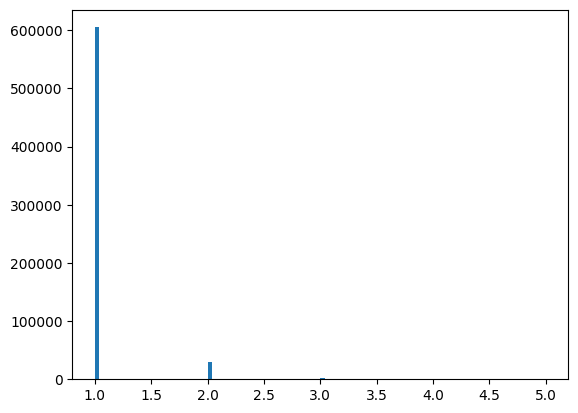

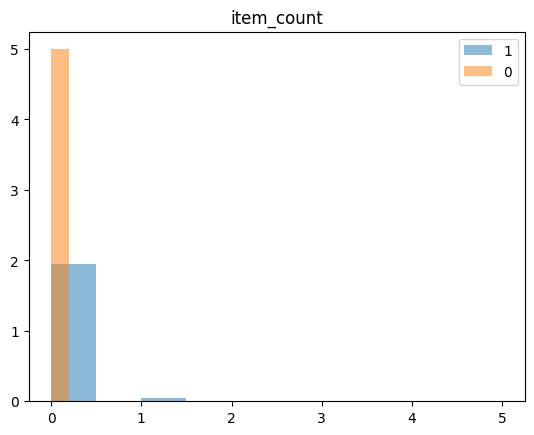

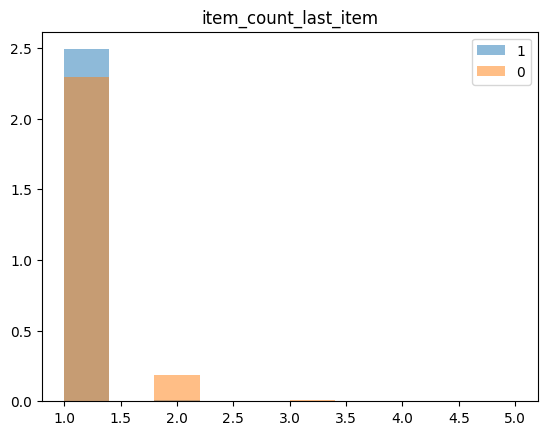

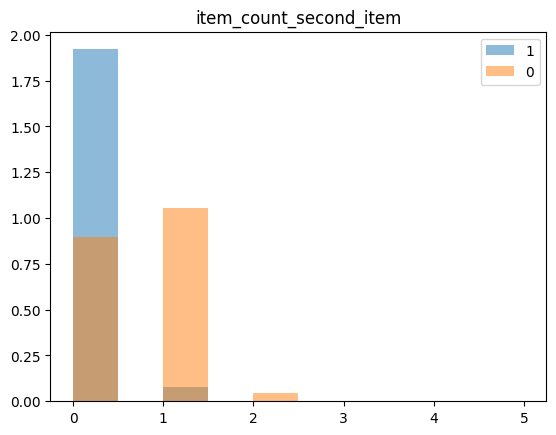

In [52]:
train_df, test_df, item_count_in_session_cols = add_item_count_in_session(train_df, test_df, train_test_log_df)

## session内に、推薦したいアイテム, last_item, second_item が何回出現したか train, test別で集計

session内だから意味ないので使わない

In [53]:
def add_item_count_in_session_sep_train_test(train_df, target_log_df):
    item_count_df = target_log_df.groupby(['session_id', 'yad_no']).size().reset_index().rename(columns={0: 'item_count_sep_train_test'})
    plt.hist(item_count_df['item_count_sep_train_test'], bins=100)
    plt.show()

    train_df = pd.merge(train_df, item_count_df, on=['session_id', 'yad_no'], how='left')
    train_df['item_count_sep_train_test'] = train_df['item_count_sep_train_test'].fillna(0).astype(np.int8)

    rename_dict = {'item_count_sep_train_test': 'item_count_last_item_sep_train_test', 'yad_no': 'last_item'}
    item_count_last_item_df = item_count_df.rename(columns=rename_dict)
    train_df = pd.merge(train_df, item_count_last_item_df, on=['session_id', 'last_item'], how='left')
    train_df['item_count_last_item_sep_train_test'] = train_df['item_count_last_item_sep_train_test'].fillna(0).astype(np.int8)

    rename_dict = {'item_count_sep_train_test': 'item_count_second_item_sep_train_test', 'yad_no': 'second_item'}
    item_count_second_item_df = item_count_df.rename(columns=rename_dict)
    train_df = pd.merge(train_df, item_count_second_item_df, on=['session_id', 'second_item'], how='left')
    train_df['item_count_second_item_sep_train_test'] = train_df['item_count_second_item_sep_train_test'].fillna(0).astype(np.int8)

    output_cols = ['item_count_sep_train_test', 'item_count_last_item_sep_train_test', 'item_count_second_item_sep_train_test']

    # plot_feature_distribution(train_df, output_cols)
    
    return train_df, output_cols


In [54]:
"""
train_df, cols = add_item_count_in_session_sep_train_test(train_df, train_log_df)
test_df, cols = add_item_count_in_session_sep_train_test(test_df, test_log_df)

plot_feature_distribution(train_df, cols)
plot_train_test_distribution(train_df, test_df, cols)
sep_train_test_cols += cols
"""

'\ntrain_df, cols = add_item_count_in_session_sep_train_test(train_df, train_log_df)\ntest_df, cols = add_item_count_in_session_sep_train_test(test_df, test_log_df)\n\nplot_feature_distribution(train_df, cols)\nplot_train_test_distribution(train_df, test_df, cols)\nsep_train_test_cols += cols\n'

## 画像

In [55]:
def add_image_category_count(train_df, test_df):

    image_parquet = pd.read_parquet('../../datasets/atmaCup16_Dataset/image_embeddings.parquet')

    image_category_count_df = pd.crosstab(image_parquet['yad_no'], image_parquet['category'])
    image_category_count_df.columns.name = None
    image_category_count_df = image_category_count_df.reset_index()
    rename_dict = dict([(col, col + '_count') for col in image_category_count_df.columns if col != 'yad_no'])
    image_category_count_df = image_category_count_df.rename(columns=rename_dict)

    image_category_count_df['image_total_num'] = image_category_count_df[rename_dict.values()].sum(axis=1)

    output_cols = list(rename_dict.values()) + ['image_total_num']

    train_df = pd.merge(train_df, image_category_count_df, on='yad_no', how='left')
    test_df = pd.merge(test_df, image_category_count_df, on='yad_no', how='left')

    # 欠損をfillna、intに変換
    train_df[output_cols] = train_df[output_cols].fillna(-1).astype(np.int8)
    test_df[output_cols] = test_df[output_cols].fillna(-1).astype(np.int8)

    plot_feature_distribution(train_df, output_cols)

    return train_df, test_df, output_cols

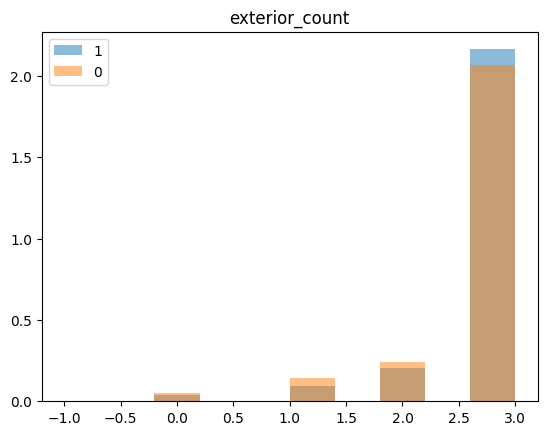

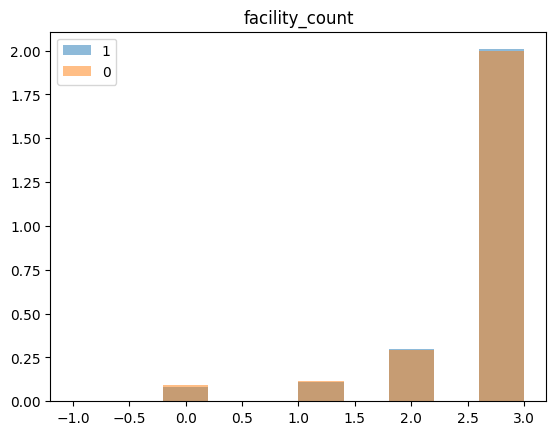

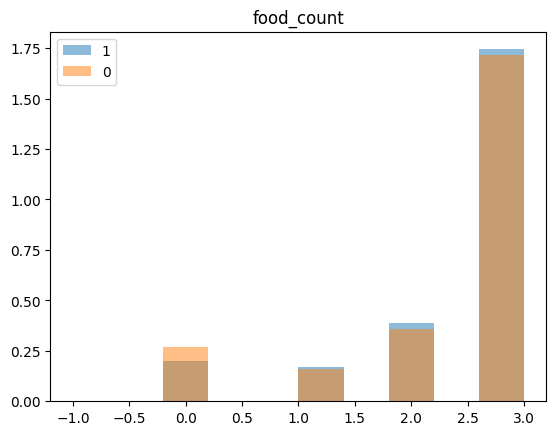

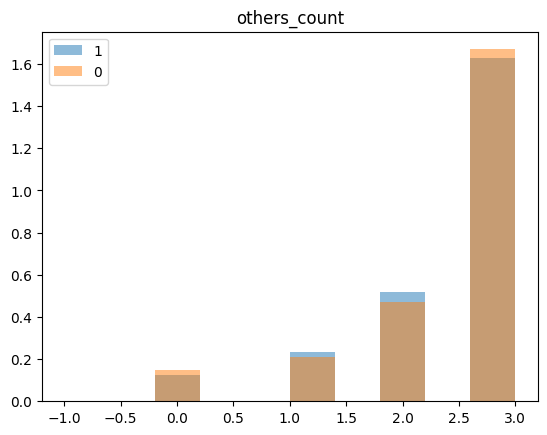

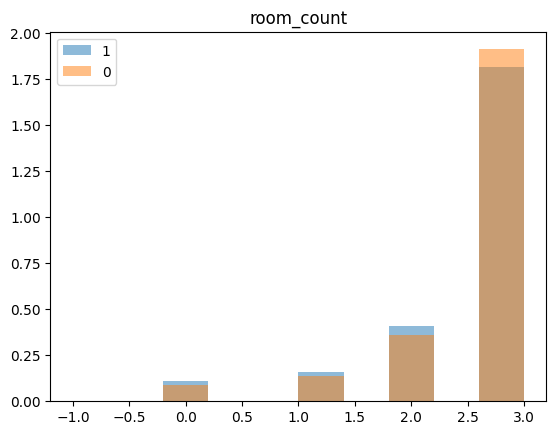

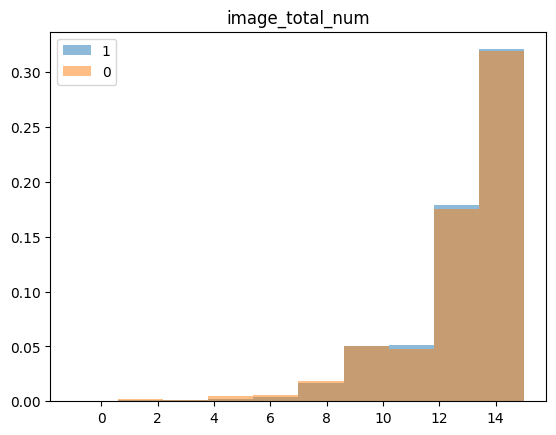

In [56]:
train_df, test_df, image_category_count_cols = add_image_category_count(train_df, test_df)

In [57]:
from sklearn.decomposition import TruncatedSVD
import umap

def add_embedding_vec(train_df, test_df, item_path, embd_name, dimensions, reduction_method='svd', n_components=16):
    item_factors_df = pd.read_pickle(item_path)

    item_factor_cols = [f'item_factor_{i}' for i in range(dimensions)]
    output_cols = [f'item_factor_{embd_name}_{i}' for i in range(n_components)]

    """
    transformer = TruncatedSVD(n_components=n_components, random_state=42)
    item_factors_df[output_cols] = transformer.fit_transform(item_factors_df[item_factor_cols]).astype(np.float16)
    """
    
    # 可視化用
    """
    transformer = umap.UMAP(
                n_components=2, random_state=42)
    debug_vec = item_factors_df[item_factor_cols].values
    use_idxs = [i for i in range(len(debug_vec)) if sum(debug_vec[i]) != 0]
    print(len(use_idxs)/ len(debug_vec))
    debug_vec = debug_vec[use_idxs, :]
    debug_vec = transformer.fit_transform(debug_vec)
    plt.scatter(debug_vec[:, 0], debug_vec[:, 1])
    plt.title(embd_name)
    plt.show()
    """

    transformer = umap.UMAP(
                n_components=n_components, random_state=42)
    item_factors_df[output_cols] = transformer.fit_transform(item_factors_df[item_factor_cols]).astype(np.float16)


    train_df = pd.merge(train_df, item_factors_df[['yad_no'] + output_cols], on='yad_no', how='left')
    test_df = pd.merge(test_df, item_factors_df[['yad_no'] + output_cols], on='yad_no', how='left')

    return train_df, test_df, output_cols

In [58]:
embedding_vec_cols = []

In [59]:
# for category in ['exterior', 'facility', 'food', 'others', 'room']:
"""
for category in ['exterior',  'room']:
    train_df, test_df, output_cols = add_embedding_vec(train_df, test_df,  f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}', 512)
    embedding_vec_cols.extend(output_cols)
"""


"\nfor category in ['exterior',  'room']:\n    train_df, test_df, output_cols = add_embedding_vec(train_df, test_df,  f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}', 512)\n    embedding_vec_cols.extend(output_cols)\n"

## cluster

In [60]:
from sklearn.cluster import KMeans
"""
secondも追加だと、fillnaする必要があるから、uint8にできない int16で
"""
def add_image_embedding_cluster(train_df, test_df, item_path, embd_name, dimensions):
    item_factors_df = pd.read_pickle(item_path)
    item_factor_cols = [f'item_factor_{i}' for i in range(dimensions)]

    kmeans = KMeans(n_clusters=255, init='k-means++',
                    random_state=CFG.seed).fit(item_factors_df[item_factor_cols].values)
    labels = kmeans.labels_

    output_cols = [f'item_factor_{embd_name}_cluster', f'item_factor_{embd_name}_cluster_last_item']

    item_factors_df[f'item_factor_{embd_name}_cluster'] = labels
    item_factors_df[f'item_factor_{embd_name}_cluster'] = item_factors_df[f'item_factor_{embd_name}_cluster'].astype(np.int16)

    train_df = pd.merge(train_df, item_factors_df[['yad_no', f'item_factor_{embd_name}_cluster']], on='yad_no', how='left')
    test_df = pd.merge(test_df, item_factors_df[['yad_no', f'item_factor_{embd_name}_cluster']], on='yad_no', how='left')

    rename_dict = {'yad_no': 'last_item', 
                   f'item_factor_{embd_name}_cluster': f'item_factor_{embd_name}_cluster_last_item'}
    item_factors_last_item_df = item_factors_df.rename(columns=rename_dict)
    train_df = pd.merge(train_df, item_factors_last_item_df[['last_item', f'item_factor_{embd_name}_cluster_last_item']], on='last_item', how='left')
    test_df = pd.merge(test_df, item_factors_last_item_df[['last_item', f'item_factor_{embd_name}_cluster_last_item']], on='last_item', how='left')

    plot_feature_distribution(train_df, output_cols)

    return train_df, test_df, output_cols

In [61]:
"""
image_embedding_cluster_cols = []
for category in ['exterior', 'facility', 'food', 'others', 'room']:
    train_df, test_df, cols = add_image_embedding_cluster(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}', 512)
    image_embedding_cluster_cols += cols
"""


"\nimage_embedding_cluster_cols = []\nfor category in ['exterior', 'facility', 'food', 'others', 'room']:\n    train_df, test_df, cols = add_image_embedding_cluster(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}', 512)\n    image_embedding_cluster_cols += cols\n"

## session内の、flg数

In [62]:
def add_yado_flg_count(train_df, test_df, yado_df, train_test_log_df):
    flg_cols = ['wireless_lan_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min']

    train_test_log_df = train_test_log_df.merge(yado_df[['yad_no'] + flg_cols], on='yad_no', how='left')

    output_cols  = []
    for flg_col in flg_cols:
        flg_count_df = pd.crosstab(train_test_log_df['session_id'], train_test_log_df[flg_col])
        flg_count_df.columns.name = None
        flg_count_df = flg_count_df.reset_index()
        rename_dict = dict([(col,  f'{flg_col}_{col}' + '_count') for col in flg_count_df.columns if col != 'session_id'])
        flg_count_df = flg_count_df.rename(columns=rename_dict)
        print(flg_count_df)
        output_cols += list(rename_dict.values()) 

        train_df = pd.merge(train_df, flg_count_df, on='session_id', how='left')
        test_df = pd.merge(test_df, flg_count_df, on='session_id', how='left')
    
    print(train_df[output_cols].dtypes)

    # plot_feature_distribution(train_df, output_cols)

    return train_df, test_df, output_cols


In [63]:
train_df, test_df, yado_flg_count_cols = add_yado_flg_count(train_df, test_df, yado_df, train_test_log_df)

                              session_id  wireless_lan_flg_0_count  \
0       000007603d533d30453cc45d0f3d119f                         0   
1       00001149e9c73985425197104712478c                         0   
2       0000ca043ed437a1472c9d1d154eb49b                         0   
3       0000d4835cf113316fe447e2f80ba1c8                         0   
4       0000e02747d749a52b7736dfa751e258                         0   
...                                  ...                       ...   
463393  ffff9a7dcc892875c7a8b821fa436228                         1   
463394  ffffb1d30300fe17f661941fd085b04b                         0   
463395  ffffcd5bc19d62cad5a3815c87818d83                         0   
463396  ffffe984aafd6127ce8e43e3ca40c79d                         0   
463397  fffffa7baf370083ebcdd98f26a7e31a                         0   

        wireless_lan_flg_1_count  
0                              1  
1                              2  
2                              1  
3                  

## 

## 地域ごとのflgの個数、割合

areaのcount encodingはdef add_yad_area_count_agg のsum

In [64]:
def add_yado_flg_agg_area(train_df, test_df, yado_df):
    yado_df = yado_df.copy()

    # area_cols = ['sml_cd', 'lrg_cd', 'ken_cd', 'wid_cd']
    area_cols = ['sml_cd', 'lrg_cd']
    flg_cols = ['wireless_lan_flg', 'kd_stn_5min', 'kd_bch_5min', 'kd_slp_5min', 'kd_conv_walk_5min']
    output_cols = []
    for area_col in area_cols:
        area_count_dict = yado_df.groupby(area_col).size().to_dict()
        yado_df[f'{area_col}_count'] = yado_df[area_col].map(area_count_dict)
        
        grp_df = yado_df.groupby(area_col)[flg_cols].agg(['sum'])

        grp_df.columns = ['_'.join(c) + f'@{area_col}' for c in grp_df.columns]

        yado_df = pd.merge(yado_df, grp_df, on=area_col, how='left')
        
        use_cols = list(grp_df.columns)
        for grp_col in grp_df.columns:
            yado_df[grp_col + '_rate'] = yado_df[grp_col] / yado_df[f'{area_col}_count']
            use_cols.append(grp_col + '_rate')
        
        train_df = pd.merge(train_df, yado_df[['yad_no'] + use_cols], on='yad_no', how='left')
        test_df = pd.merge(test_df, yado_df[['yad_no'] + use_cols], on='yad_no', how='left')

        output_cols += use_cols
    
    print(train_df[output_cols].dtypes)
    train_df[output_cols] = train_df[output_cols].astype(np.float16)
    test_df[output_cols] = test_df[output_cols].astype(np.float16)

    plot_feature_distribution(train_df, output_cols)
    
    return train_df, test_df, output_cols

In [65]:
# train_df, test_df, yado_flg_agg_area_cols = add_yado_flg_agg_area(train_df, test_df, yado_df)

In [66]:
def add_yado_area_label_encoding(train_df, test_df, yado_df):
    area_cols = ['sml_cd', 'lrg_cd', 'ken_cd', 'wid_cd']
    output_cols = [col + '_num' for col in area_cols]

    yado_df = yado_df.copy()

    for col in area_cols:
        areas = yado_df[col].unique()

        area_to_num = dict([(area, i) for i, area in enumerate(areas)])
        yado_df[col + '_num'] = yado_df[col].map(area_to_num)
    
    train_df = train_df.merge(yado_df[['yad_no'] + output_cols], on='yad_no', how='left')
    test_df = test_df.merge(yado_df[['yad_no'] + output_cols], on='yad_no', how='left')
    

    return train_df, test_df, output_cols


In [67]:
train_df, test_df, yado_area_label_encoding_cols = add_yado_area_label_encoding(train_df, test_df, yado_df)

In [68]:
train_df[yado_area_label_encoding_cols]

,sml_cd_num,lrg_cd_num,ken_cd_num,wid_cd_num
0,293,164,31,8
1,293,164,31,8
2,293,164,31,8
3,293,164,31,8
4,293,164,31,8
...,...,...,...,...
11100689,291,2,2,2
11100690,291,2,2,2
11100691,291,2,2,2
11100692,291,2,2,2


In [69]:
def add_yado_cols(train_df, test_df, yado_df):

    yad_cols = ['yad_type','total_room_cnt','wireless_lan_flg','onsen_flg','kd_stn_5min','kd_bch_5min','kd_slp_5min','kd_conv_walk_5min']
    # 1stageはyad_colsを減らす
    # yad_cols = ['total_room_cnt']
    area_cols = ['sml_cd', 'lrg_cd']

    train_df = pd.merge(train_df, yado_df[['yad_no'] + yad_cols + area_cols], on='yad_no', how='left')
    test_df = pd.merge(test_df, yado_df[['yad_no'] + yad_cols + area_cols], on='yad_no', how='left')

    yado_last_item_df = yado_df.copy()
    yado_last_item_df.rename(columns={'yad_no': 'last_item'}, inplace=True)
    yad_last_cols = [col + '_last_item' for col in yad_cols]
    rename_dict = dict(zip(yad_cols, yad_last_cols))
    yado_last_item_df.rename(columns=rename_dict, inplace=True)

    train_df = pd.merge(train_df, yado_last_item_df[['last_item'] + yad_last_cols], on='last_item', how='left')
    test_df = pd.merge(test_df, yado_last_item_df[['last_item'] + yad_last_cols], on='last_item', how='left')

    # second_item 追加
    yado_second_item_df = yado_df.copy()
    yado_second_item_df.rename(columns={'yad_no': 'second_item'}, inplace=True)
    yad_second_cols = [col + '_second_item' for col in yad_cols]
    rename_dict = dict(zip(yad_cols, yad_second_cols))
    yado_second_item_df.rename(columns=rename_dict, inplace=True)

    train_df = pd.merge(train_df, yado_second_item_df[['second_item'] + yad_second_cols], on='second_item', how='left')
    test_df = pd.merge(test_df, yado_second_item_df[['second_item'] + yad_second_cols], on='second_item', how='left')

    train_df[yad_second_cols] = train_df[yad_second_cols].fillna(-1).astype(np.int16)
    test_df[yad_second_cols] = test_df[yad_second_cols].fillna(-1).astype(np.int16)

    # 1stageは使わない
    yad_area_agg_cols = ['total_room_cnt']
    # yad_area_agg_cols = ['yad_type','total_room_cnt','wireless_lan_flg','onsen_flg','kd_stn_5min','kd_bch_5min','kd_slp_5min','kd_conv_walk_5min']
    for area_col in area_cols:
        grp_df = yado_df.groupby(area_col)[yad_area_agg_cols].agg(['mean', 'max', 'min', 'std', 'median'])
        grp_df.columns = ['_'.join(c) + f'@{area_col}' for c in grp_df.columns]

        train_df = pd.merge(train_df, grp_df, on=area_col, how='left')
        test_df = pd.merge(test_df, grp_df, on=area_col, how='left')
        
        print(grp_df.columns)
        yad_cols += grp_df.columns.tolist()
    
    # last_itemをkeyにして、yad_noのarea_colをmerge
    rename_cols = dict([(col, f'{col}_last_item') for col in area_cols])
    rename_cols['yad_no'] = 'last_item'

    train_df = pd.merge(train_df, yado_df[['yad_no'] + area_cols].rename(columns=rename_cols), on='last_item', how='left')
    test_df = pd.merge(test_df, yado_df[['yad_no'] + area_cols].rename(columns=rename_cols), on='last_item', how='left')

    for col in area_cols:
        train_df[f'last_item_is_same_{col}'] = (train_df[col] == train_df[f'{col}_last_item']).astype(int)
        test_df[f'last_item_is_same_{col}'] = (test_df[col] == test_df[f'{col}_last_item']).astype(int)

        yad_cols += [f'last_item_is_same_{col}']

    for col in area_cols:
        print(train_df[f'last_item_is_same_{col}'].value_counts())
        print(test_df[f'last_item_is_same_{col}'].value_counts())

    return train_df, test_df, yad_cols, yad_last_cols, yad_second_cols

In [70]:
train_df, test_df, yad_cols, yad_last_cols, yad_second_cols = add_yado_cols(train_df, test_df, yado_df)

Index(['total_room_cnt_mean@sml_cd', 'total_room_cnt_max@sml_cd',
       'total_room_cnt_min@sml_cd', 'total_room_cnt_std@sml_cd',
       'total_room_cnt_median@sml_cd'],
      dtype='object')
Index(['total_room_cnt_mean@lrg_cd', 'total_room_cnt_max@lrg_cd',
       'total_room_cnt_min@lrg_cd', 'total_room_cnt_std@lrg_cd',
       'total_room_cnt_median@lrg_cd'],
      dtype='object')
last_item_is_same_sml_cd
1    8145732
0    2954962
Name: count, dtype: int64
last_item_is_same_sml_cd
1    4870935
0    1766544
Name: count, dtype: int64
last_item_is_same_lrg_cd
1    10830831
0      269863
Name: count, dtype: int64
last_item_is_same_lrg_cd
1    6456747
0     180732
Name: count, dtype: int64


In [71]:
print(yad_last_cols)
print('second')
print(yad_second_cols)

['yad_type_last_item', 'total_room_cnt_last_item', 'wireless_lan_flg_last_item', 'onsen_flg_last_item', 'kd_stn_5min_last_item', 'kd_bch_5min_last_item', 'kd_slp_5min_last_item', 'kd_conv_walk_5min_last_item']
second
['yad_type_second_item', 'total_room_cnt_second_item', 'wireless_lan_flg_second_item', 'onsen_flg_second_item', 'kd_stn_5min_second_item', 'kd_bch_5min_second_item', 'kd_slp_5min_second_item', 'kd_conv_walk_5min_second_item']


## yadの出現回数、sessionのunique数

In [72]:
def add_yad_occur_count(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    
    yad_occur_count_df = target_log_df.groupby('yad_no').size().reset_index()
    yad_occur_count_df.rename(columns={0: 'yad_occur_count'}, inplace=True)
    target_df = pd.merge(target_df, yad_occur_count_df, on='yad_no', how='left')

    yad_session_nunique_df = target_log_df.groupby('yad_no')['session_id'].nunique().reset_index()
    yad_session_nunique_df.rename(columns={'session_id': 'yad_session_nunique'}, inplace=True)
    target_df = pd.merge(target_df, yad_session_nunique_df, on='yad_no', how='left')
    
    return target_df

train_df = add_yad_occur_count(train_df, train_test_log_df)
test_df = add_yad_occur_count(test_df, train_test_log_df)

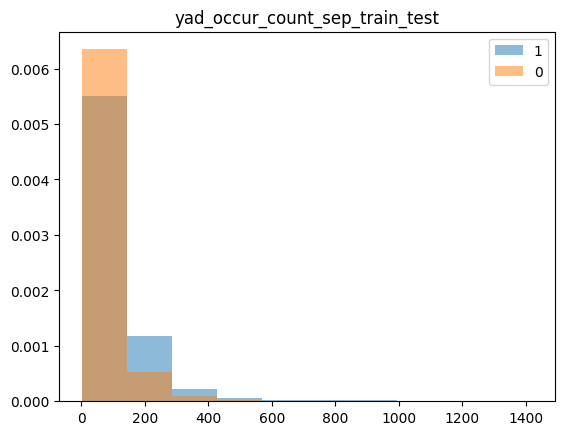

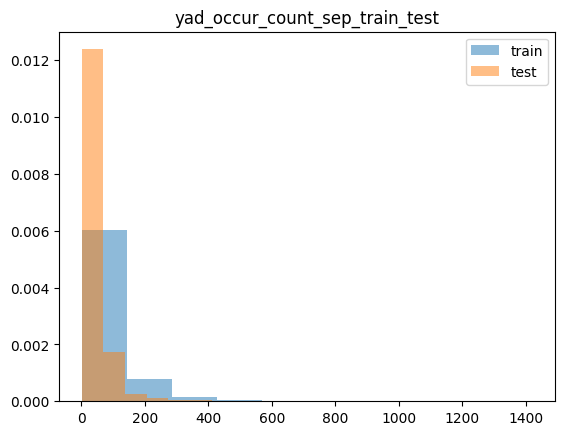

In [73]:
def add_yad_occur_count_sep_train_test(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    
    yad_occur_count_df = target_log_df.groupby('yad_no').size().reset_index()
    yad_occur_count_df.rename(columns={0: 'yad_occur_count_sep_train_test'}, inplace=True)
    target_df = pd.merge(target_df, yad_occur_count_df, on='yad_no', how='left')
    
    output_cols = ['yad_occur_count_sep_train_test']
    return target_df, output_cols

train_df, cols = add_yad_occur_count_sep_train_test(train_df, train_log_df)
test_df, cols = add_yad_occur_count_sep_train_test(test_df, test_log_df)

plot_feature_distribution(train_df, cols)
plot_train_test_distribution(train_df, test_df, cols)
sep_train_test_cols += cols

## yad_noの出現回数をareaで集約 

In [74]:
def add_yad_area_count_agg(train_df, test_df, train_test_log_df):
    train_test_log_df_yado = train_test_log_df.merge(yado_df, on='yad_no', how='left')
    
    area_cols = ['sml_cd', 'lrg_cd']
    yad_area_count_agg_cols = []
    for col in area_cols:
        count_df = train_test_log_df_yado.groupby([col, 'yad_no']).size().reset_index()
        count_df.rename(columns={0: f'yad_no_count_{col}'}, inplace=True)

        grp_df = count_df.groupby(col)[[f'yad_no_count_{col}']].agg(['mean', 'max', 'min', 'std', 'median', 'sum'])
        grp_df.columns = ['_'.join(c) + f'@{col}' for c in grp_df.columns]

        train_df = pd.merge(train_df, grp_df, on=col, how='left')
        test_df = pd.merge(test_df, grp_df, on=col, how='left')

        yad_area_count_agg_cols += grp_df.columns.tolist()

        """
        train_df[f'yad_occur_count_div_yad_no_count_{col}_sum@{col}'] = train_df['yad_occur_count'] / train_df[f'yad_no_count_{col}_sum@{col}']
        test_df[f'yad_occur_count_div_yad_no_count_{col}_sum@{col}'] = test_df['yad_occur_count'] / test_df[f'yad_no_count_{col}_sum@{col}']
        train_df[f'yad_occur_count_div_yad_no_count_{col}_max@{col}'] = train_df['yad_occur_count'] / train_df[f'yad_no_count_{col}_max@{col}']
        test_df[f'yad_occur_count_div_yad_no_count_{col}_max@{col}'] = test_df['yad_occur_count'] / test_df[f'yad_no_count_{col}_max@{col}']

        yad_area_count_agg_cols += [f'yad_occur_count_div_yad_no_count_{col}_sum@{col}', f'yad_occur_count_div_yad_no_count_{col}_max@{col}']

        plot_feature_distribution(train_df, [f'yad_occur_count_div_yad_no_count_{col}_sum@{col}', f'yad_occur_count_div_yad_no_count_{col}_max@{col}'])
        """
    # sep_train_testでは省メモリ
    train_df[yad_area_count_agg_cols] = train_df[yad_area_count_agg_cols].astype(np.float16)
    test_df[yad_area_count_agg_cols] = test_df[yad_area_count_agg_cols].astype(np.float16)

    return train_df, test_df, yad_area_count_agg_cols

train_df, test_df, yad_area_count_agg_cols = add_yad_area_count_agg(train_df, test_df, train_test_log_df)

## area内での、出現回数のrank

In [75]:
def add_rank_same_area(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame, yado_df: pd.DataFrame, area_col:str):
    counter = Counter(train_test_log_df['yad_no'].values)
    sml_cd_to_yad_dict = yado_df.groupby(area_col)['yad_no'].apply(lambda x: x.tolist()).to_dict()

    # counterの値で、yad_noをソート
    for sml_cd in sml_cd_to_yad_dict.keys():
        sml_cd_to_yad_dict[sml_cd] = sorted(sml_cd_to_yad_dict[sml_cd], key=lambda x: counter[x], reverse=True)

    results = []
    columns = [f'yad_occur_rank_{area_col}']
    for sml_cd in sml_cd_to_yad_dict.keys():
        yad_no_list = sml_cd_to_yad_dict[sml_cd]
        for rank, yad_no in enumerate(yad_no_list):
            # results.append([sml_cd, yad_no, counter[yad_no], rank+1])
            results.append([yad_no, rank+1])
            
    sml_cd_count_df = pd.DataFrame(results, columns=['yad_no'] + columns)

    train_df = pd.merge(train_df, sml_cd_count_df, on=['yad_no'], how='left')
    test_df = pd.merge(test_df, sml_cd_count_df, on=['yad_no'], how='left')

    return train_df, test_df, columns

In [76]:
# 関数化してなかったせいでarea_colがglobal、他の関数(add_yad_area_count_agg)で使われていた
def add_rank_same_area_main(train_df, test_df, train_test_log_df, yado_df):
    yad_count_cols = []

    for area_col in ['sml_cd', 'wid_cd', 'ken_cd', 'lrg_cd']:
        train_df, test_df, cols = add_rank_same_area(train_df, test_df, train_test_log_df, yado_df, area_col)
        yad_count_cols += cols

    return train_df, test_df, yad_count_cols

In [77]:
train_df, test_df, yad_count_cols = add_rank_same_area_main(train_df, test_df, train_test_log_df, yado_df)

## area内での、出現回数のrank train,test別

In [78]:
def add_rank_same_area_sep_train_test(train_df: pd.DataFrame, target_log_df: pd.DataFrame, yado_df: pd.DataFrame, area_col:str):
    counter = Counter(target_log_df['yad_no'].values)
    sml_cd_to_yad_dict = yado_df.groupby(area_col)['yad_no'].apply(lambda x: x.tolist()).to_dict()

    # counterの値で、yad_noをソート
    for sml_cd in sml_cd_to_yad_dict.keys():
        sml_cd_to_yad_dict[sml_cd] = sorted(sml_cd_to_yad_dict[sml_cd], key=lambda x: counter[x], reverse=True)

    results = []
    columns = [f'yad_occur_rank_{area_col}_sep_train_test']
    for sml_cd in sml_cd_to_yad_dict.keys():
        yad_no_list = sml_cd_to_yad_dict[sml_cd]
        for rank, yad_no in enumerate(yad_no_list):
            # results.append([sml_cd, yad_no, counter[yad_no], rank+1])
            results.append([yad_no, rank+1])
            
    sml_cd_count_df = pd.DataFrame(results, columns=['yad_no'] + columns)

    train_df = pd.merge(train_df, sml_cd_count_df, on=['yad_no'], how='left')
    # test_df = pd.merge(test_df, sml_cd_count_df, on=['yad_no'], how='left')

    return train_df, columns

In [79]:
# 関数化してなかったせいでarea_colがglobal、他の関数(add_yad_area_count_agg)で使われていた
def add_rank_same_area_main_sep_train_test(train_df, test_df, train_log_df,test_log_df, yado_df):
    yad_count_cols = []

    for area_col in ['sml_cd', 'wid_cd', 'ken_cd', 'lrg_cd']:
        train_df, cols = add_rank_same_area_sep_train_test(train_df, train_log_df, yado_df, area_col)
        test_df, cols = add_rank_same_area_sep_train_test(test_df, test_log_df, yado_df, area_col)
        
        plot_feature_distribution(train_df, cols)
        plot_train_test_distribution(train_df, test_df, cols)
        yad_count_cols += cols

    return train_df, test_df, yad_count_cols

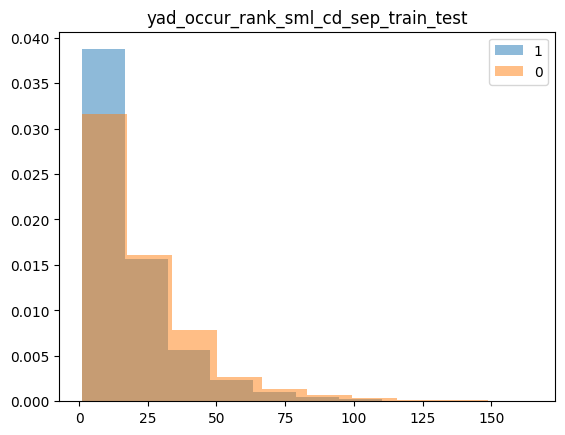

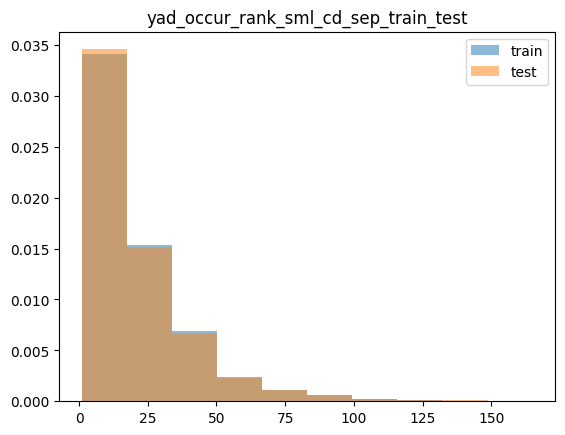

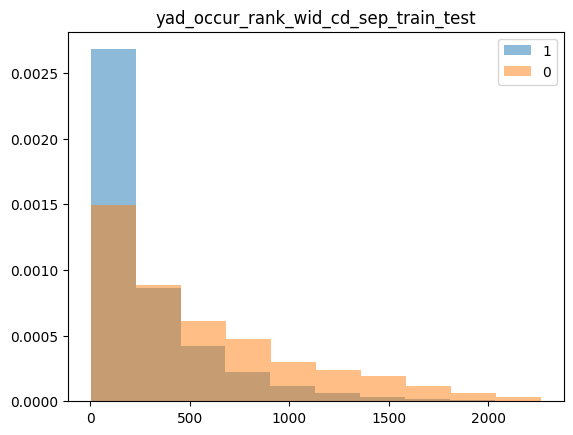

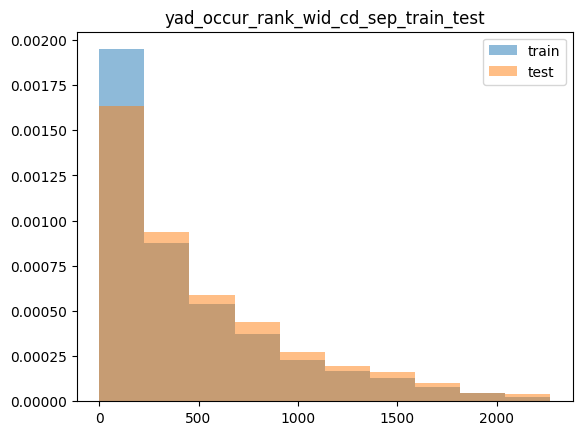

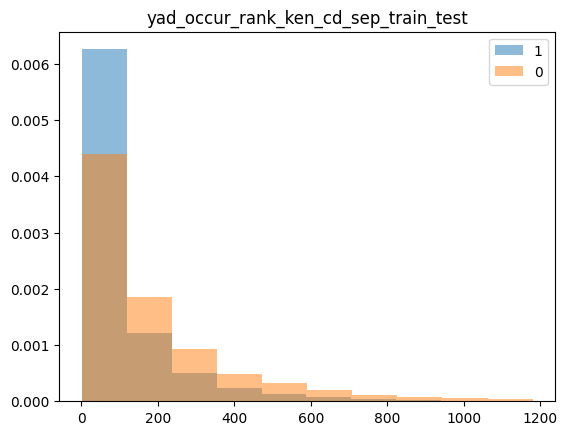

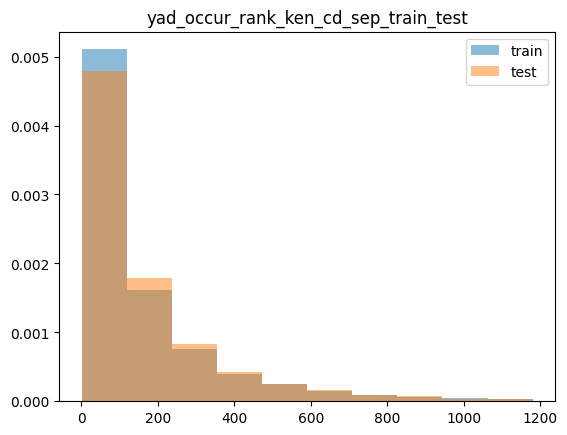

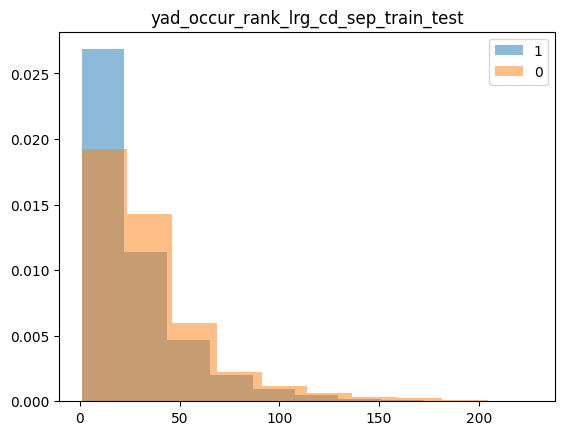

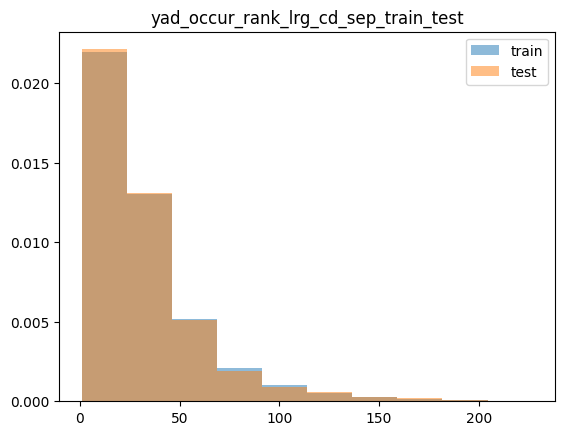

In [80]:
train_df, test_df, cols = add_rank_same_area_main_sep_train_test(train_df, test_df, train_log_df, test_log_df, yado_df)
sep_train_test_cols += cols

## user feature

In [81]:
def add_user_cols(train_df, test_df, train_test_log_df):
    user_cols = ['session_item_count', 'session_item_nunique']

    session_item_count_df = train_test_log_df.groupby('session_id').size().reset_index()
    session_item_count_df.rename(columns={0: 'session_item_count'}, inplace=True)
    train_df = pd.merge(train_df, session_item_count_df, on='session_id', how='left')
    test_df = pd.merge(test_df, session_item_count_df, on='session_id', how='left')

    session_item_nunique_df = train_test_log_df.groupby('session_id')['yad_no'].nunique().reset_index()
    session_item_nunique_df.rename(columns={'yad_no': 'session_item_nunique'}, inplace=True)
                                  
    train_df = pd.merge(train_df, session_item_nunique_df, on='session_id', how='left')
    test_df = pd.merge(test_df, session_item_nunique_df, on='session_id', how='left')

    return train_df, test_df, user_cols

In [82]:
train_df, test_df, user_cols = add_user_cols(train_df, test_df, train_test_log_df)

## last_itemの出現回数、area内での出現回数,rank

In [83]:
def add_yad_occur_count_last_item(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    target_log_df = target_log_df.rename(columns={'yad_no': 'last_item'})

    yad_occur_count_df = target_log_df.groupby('last_item').size().reset_index()
    yad_occur_count_df.rename(columns={0: 'yad_occur_count_last_item'}, inplace=True)
    target_df = pd.merge(target_df, yad_occur_count_df, on='last_item', how='left')

    yad_session_nunique_df = target_log_df.groupby('last_item')['session_id'].nunique().reset_index()
    yad_session_nunique_df.rename(columns={'session_id': 'yad_session_nunique_last_item'}, inplace=True)
    target_df = pd.merge(target_df, yad_session_nunique_df, on='last_item', how='left')
    
    return target_df

def add_rank_same_area_last_item(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame, yado_df: pd.DataFrame, area_col:str):
    counter = Counter(train_test_log_df['yad_no'].values)
    sml_cd_to_yad_dict = yado_df.groupby(area_col)['yad_no'].apply(lambda x: x.tolist()).to_dict()

    # counterの値で、yad_noをソート
    for sml_cd in sml_cd_to_yad_dict.keys():
        sml_cd_to_yad_dict[sml_cd] = sorted(sml_cd_to_yad_dict[sml_cd], key=lambda x: counter[x], reverse=True)

    results = []
    columns = [f'yad_occur_rank_last_item_{area_col}']
    for sml_cd in sml_cd_to_yad_dict.keys():
        yad_no_list = sml_cd_to_yad_dict[sml_cd]
        for rank, yad_no in enumerate(yad_no_list):
            # results.append([sml_cd, yad_no, counter[yad_no], rank+1])
            results.append([yad_no, rank+1])
            
    sml_cd_count_df = pd.DataFrame(results, columns=['last_item'] + columns)

    train_df = pd.merge(train_df, sml_cd_count_df, on=['last_item'], how='left')
    test_df = pd.merge(test_df, sml_cd_count_df, on=['last_item'], how='left')

    return train_df, test_df, columns

In [84]:
yad_count_last_item_cols = ['yad_occur_count_last_item', 'yad_session_nunique_last_item']

train_df = add_yad_occur_count_last_item(train_df, train_test_log_df)
test_df = add_yad_occur_count_last_item(test_df, train_test_log_df)

for area_col in ['sml_cd', 'wid_cd', 'ken_cd', 'lrg_cd']:
    train_df, test_df, cols = add_rank_same_area_last_item(train_df, test_df, train_test_log_df, yado_df, area_col)
    yad_count_last_item_cols += cols

## last_itemの出現回数、area内での出現回数,rank train,test別

In [85]:
def add_yad_occur_count_last_item_sep_train_test(target_df: pd.DataFrame, target_log_df: pd.DataFrame) -> pd.DataFrame:
    target_log_df = target_log_df.rename(columns={'yad_no': 'last_item'})
    
    yad_occur_count_df = target_log_df.groupby('last_item').size().reset_index()
    yad_occur_count_df.rename(columns={0: 'yad_occur_count_last_item_sep_train_test'}, inplace=True)
    target_df = pd.merge(target_df, yad_occur_count_df, on='last_item', how='left')

    yad_session_nunique_df = target_log_df.groupby('last_item')['session_id'].nunique().reset_index()
    yad_session_nunique_df.rename(columns={'session_id': 'yad_session_nunique_last_item_sep_train_test'}, inplace=True)
    target_df = pd.merge(target_df, yad_session_nunique_df, on='last_item', how='left')
    
    output_cols = ['yad_occur_count_last_item_sep_train_test', 'yad_session_nunique_last_item_sep_train_test']
    return target_df, output_cols

def add_rank_same_area_last_item_sep_train_test(train_df: pd.DataFrame, target_log_df: pd.DataFrame, yado_df: pd.DataFrame, area_col:str):
    counter = Counter(target_log_df['yad_no'].values)
    sml_cd_to_yad_dict = yado_df.groupby(area_col)['yad_no'].apply(lambda x: x.tolist()).to_dict()

    # counterの値で、yad_noをソート
    for sml_cd in sml_cd_to_yad_dict.keys():
        sml_cd_to_yad_dict[sml_cd] = sorted(sml_cd_to_yad_dict[sml_cd], key=lambda x: counter[x], reverse=True)

    results = []
    columns = [f'yad_occur_rank_last_item_sep_train_test_{area_col}']
    for sml_cd in sml_cd_to_yad_dict.keys():
        yad_no_list = sml_cd_to_yad_dict[sml_cd]
        for rank, yad_no in enumerate(yad_no_list):
            # results.append([sml_cd, yad_no, counter[yad_no], rank+1])
            results.append([yad_no, rank+1])
            
    sml_cd_count_df = pd.DataFrame(results, columns=['last_item'] + columns)

    train_df = pd.merge(train_df, sml_cd_count_df, on=['last_item'], how='left')
    # test_df = pd.merge(test_df, sml_cd_count_df, on=['last_item'], how='left')

    return train_df, columns

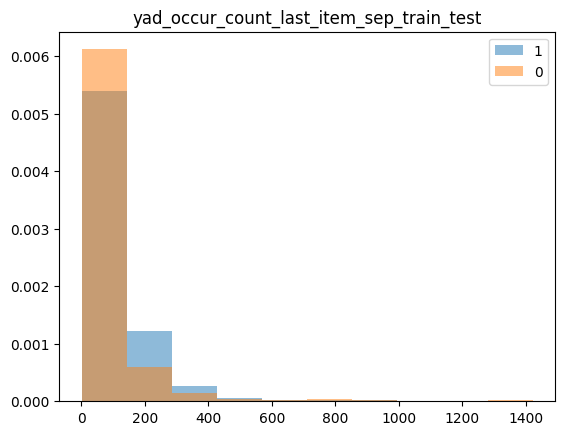

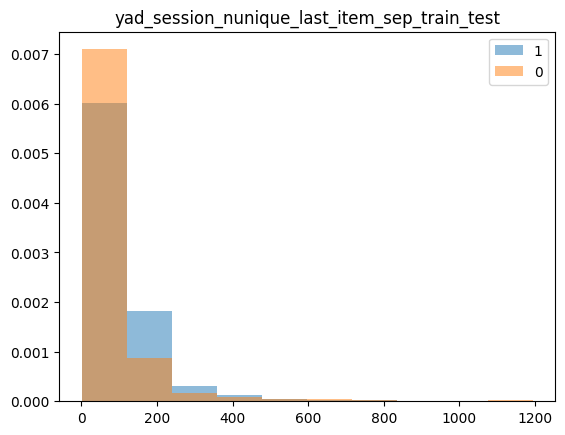

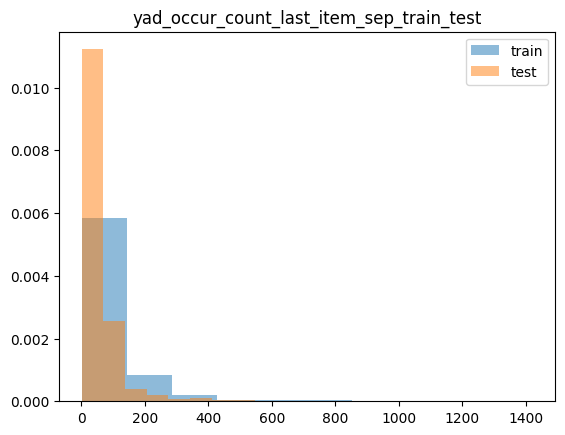

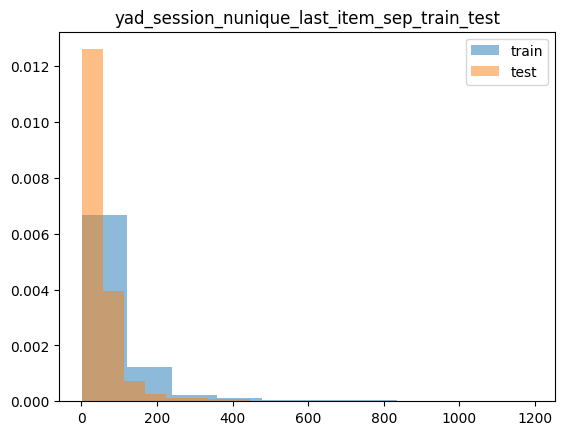

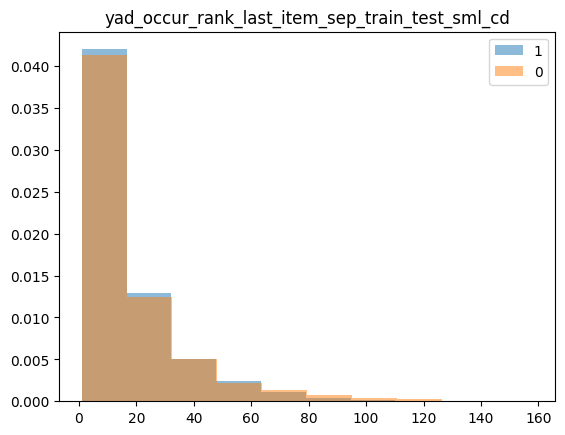

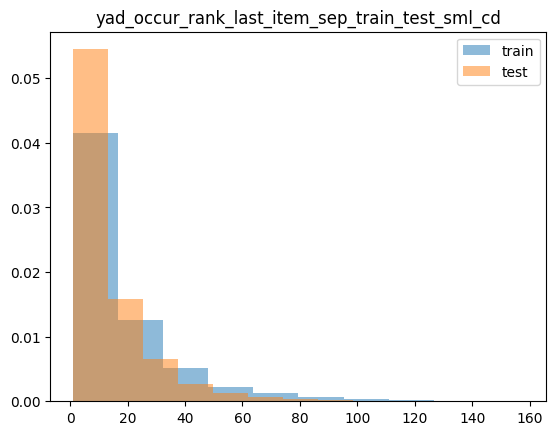

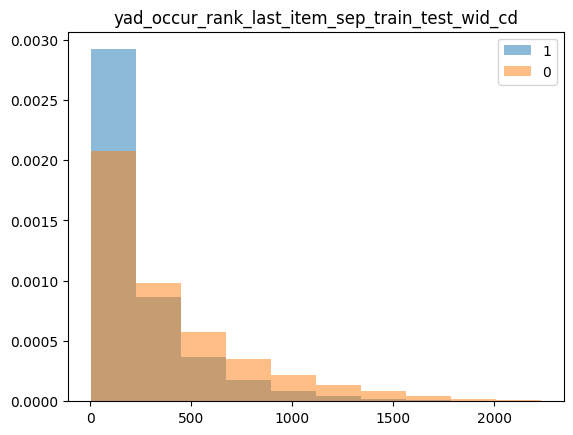

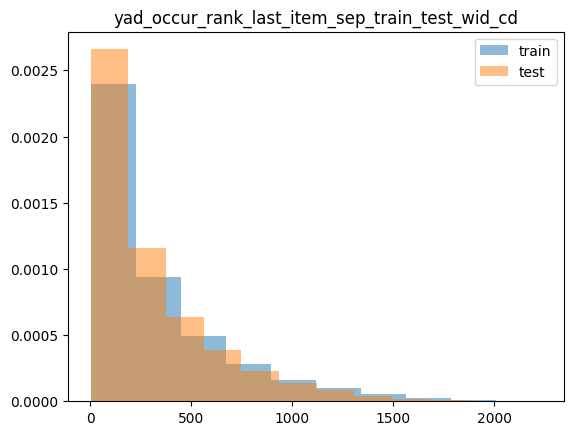

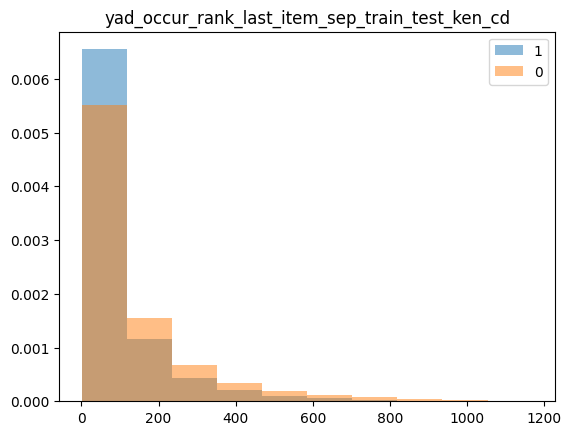

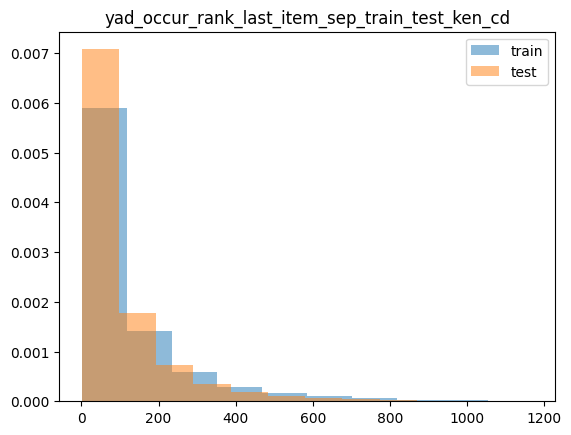

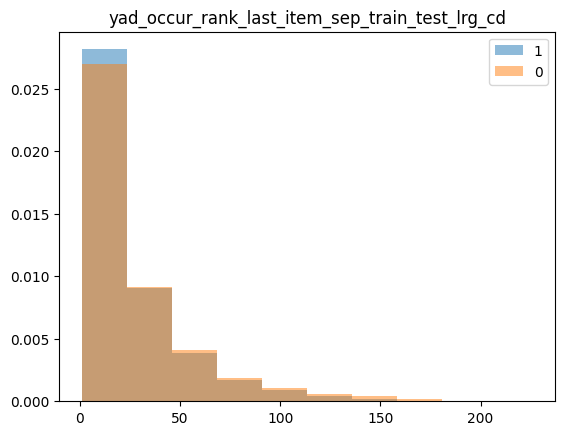

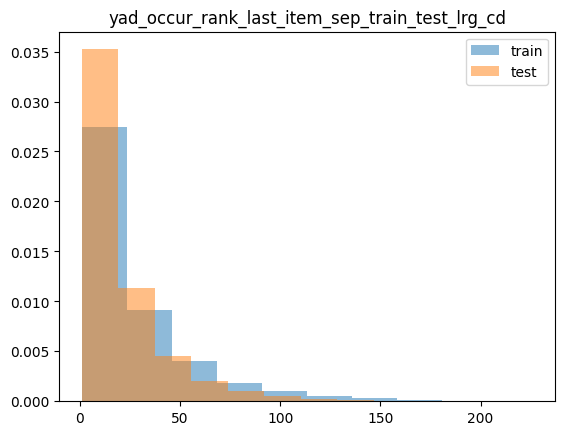

In [86]:
train_df, cols = add_yad_occur_count_last_item_sep_train_test(train_df, train_log_df)
test_df, cols = add_yad_occur_count_last_item_sep_train_test(test_df, test_log_df)
plot_feature_distribution(train_df, cols)
plot_train_test_distribution(train_df, test_df, cols)
sep_train_test_cols += cols

for area_col in ['sml_cd', 'wid_cd', 'ken_cd', 'lrg_cd']:
    train_df, cols = add_rank_same_area_last_item_sep_train_test(train_df, train_log_df, yado_df, area_col)
    test_df, cols = add_rank_same_area_last_item_sep_train_test(test_df, test_log_df, yado_df, area_col)
    plot_feature_distribution(train_df, cols)
    plot_train_test_distribution(train_df, test_df, cols)
    sep_train_test_cols += cols

## last itemとの類似度

In [87]:
from scipy.stats import rankdata

## jaccard係数

In [88]:
def add_last_item_set_similarity(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame):
    train_test_session_df = train_test_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

    yad_to_sets_dict = dict([(i, set()) for i in range(1, yado_df['yad_no'].max()+1)])

    for yads in train_test_session_df['yad_no'].values:
        if len(yads) == 1:
            continue
        for i in range(len(yads)-1):
            yad_to_sets_dict[yads[i]].add(yads[i+1])
            yad_to_sets_dict[yads[i+1]].add(yads[i])

    output_cols = ['jaccard_last_item', 'dice_last_item']
    for target_df in [train_df, test_df]:
        results = []
        for last_yad, yad in tqdm(target_df[['last_item', 'yad_no']].values):
            s1_len = len(yad_to_sets_dict[last_yad])
            s2_len = len(yad_to_sets_dict[yad])

            intersection_set = yad_to_sets_dict[last_yad] & yad_to_sets_dict[yad]
            union_set = yad_to_sets_dict[last_yad] | yad_to_sets_dict[yad]

            intersection_len = len(intersection_set)
            union_len = len(union_set)

            jaccard = intersection_len / union_len if union_len != 0 else 0
            dice = 2 * intersection_len / (s1_len + s2_len) if (s1_len + s2_len) != 0 else 0

            results.append([jaccard, dice])
        
        target_df[output_cols] = results
    
    plot_feature_distribution(train_df, output_cols)

    return train_df, test_df, output_cols

In [89]:
# train_df, test_df, last_item_set_similarity_cols = add_last_item_set_similarity(train_df, test_df, train_test_log_df)

## coo_marrix

In [90]:
def counter_init():
    return dict([(i, defaultdict(int)) for i in range(1, yado_df['yad_no'].max()+1)])

def counter_to_rank(target_counter):
    counter_rank = counter_init()
    for yad, counter in tqdm(target_counter.items()):
        keys = list(counter.keys())
        counts = list(counter.values())

        if len(counts) == 0:
            continue

        ranks = rankdata([-c for c in counts], method='min')

        for key, rank in zip(keys, ranks):
            counter_rank[yad][key] = rank

    return counter_rank

def add_last_item_coo_count(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame):

    train_df, test_df, output_cols, return_flag = add_feature_cache(train_df, test_df, sys._getframe().f_code.co_name)
    if return_flag:
        return train_df, test_df, output_cols


    train_test_session_df = train_test_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

    counter_num = 5
    counters = [counter_init() for _ in range(counter_num)]

    for yads in train_test_session_df['yad_no'].values:
        if len(yads) == 1:
            continue
        for i in range(len(yads)-1):
            counters[0][yads[i]][yads[i+1]] += 1
            counters[0][yads[i+1]][yads[i]] += 1

            counters[1][yads[i]][yads[i+1]] += 1

        for i in range(len(yads)-1):
            for j in range(i+1, len(yads)):
                counters[2][yads[i]][yads[j]] += 1
                counters[2][yads[j]][yads[i]] += 1

                counters[3][yads[i]][yads[j]] += 1
        
        for i in range(len(yads)-1):
            counters[4][yads[i]][yads[-1]] += 1
    
    # counterをrankにする
    rankers = [counter_to_rank(counter) for counter in counters]

    output_cols = [f'last_item_coo_count_{i}' for i in range(counter_num)] + [f'last_item_coo_count_{i}_rank' for i in range(counter_num)]+ \
                  [f'second_item_coo_count_{i}' for i in range(counter_num)] + [f'second_item_coo_count_{i}_rank' for i in range(counter_num)]

    for target_df in [train_df, test_df]:
        results = []
        for last_yad, second_yad, yad in target_df[['last_item', 'second_item', 'yad_no']].values:
            last_yad_res = [counters[i][last_yad][yad] for _ in range(counter_num)] + [rankers[i][last_yad][yad] for _ in range(counter_num)]

            if second_yad != -1:
                second_yad_res = [counters[i][second_yad][yad] for _ in range(counter_num)] + [rankers[i][second_yad][yad] for _ in range(counter_num)]
            else:
                second_yad_res = [-1] * (counter_num*2)
            results.append(last_yad_res + second_yad_res)
        
        target_df[output_cols] = results

    rank_cols = [col for col in output_cols if 'rank' in col]
    for col in rank_cols:
        train_df.loc[train_df[col] == 0, col] = 999999
        test_df.loc[test_df[col] == 0, col] = 999999
    
    # plot_feature_distribution(train_df, output_cols)

    make_feature_cache(train_df, test_df, output_cols, sys._getframe().f_code.co_name)

    return train_df, test_df, output_cols

In [91]:
train_df, test_df, last_item_coo_count_cols = add_last_item_coo_count(train_df, test_df, train_test_log_df)

load: add_last_item_coo_count


## coo_matrix train_test別

In [92]:
def add_last_item_coo_count_sep_train_test(target_df: pd.DataFrame, target_log_df: pd.DataFrame):
    """
    train_df, test_df, output_cols, return_flag = add_feature_cache(train_df, test_df, sys._getframe().f_code.co_name)
    if return_flag:
        return train_df, test_df, output_cols
    """

    target_session_df = target_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

    counter_num = 5
    counters = [counter_init() for _ in range(counter_num)]

    for yads in target_session_df['yad_no'].values:
        if len(yads) == 1:
            continue
        for i in range(len(yads)-1):
            counters[0][yads[i]][yads[i+1]] += 1
            counters[0][yads[i+1]][yads[i]] += 1

            counters[1][yads[i]][yads[i+1]] += 1

        for i in range(len(yads)-1):
            for j in range(i+1, len(yads)):
                counters[2][yads[i]][yads[j]] += 1
                counters[2][yads[j]][yads[i]] += 1

                counters[3][yads[i]][yads[j]] += 1
        
        for i in range(len(yads)-1):
            counters[4][yads[i]][yads[-1]] += 1
    
    # counterをrankにする
    rankers = [counter_to_rank(counter) for counter in counters]

    output_cols = [f'last_item_coo_count_{i}' for i in range(counter_num)] + [f'last_item_coo_count_{i}_rank' for i in range(counter_num)]+ \
                  [f'second_item_coo_count_{i}' for i in range(counter_num)] + [f'second_item_coo_count_{i}_rank' for i in range(counter_num)]
    output_cols = [col + '_sep_train_test' for col in output_cols]

    # for target_df in [train_df, test_df]:
    results = []
    for last_yad, second_yad, yad in target_df[['last_item', 'second_item', 'yad_no']].values:
        last_yad_res = [counters[i][last_yad][yad] for _ in range(counter_num)] + [rankers[i][last_yad][yad] for _ in range(counter_num)]

        if second_yad != -1:
            second_yad_res = [counters[i][second_yad][yad] for _ in range(counter_num)] + [rankers[i][second_yad][yad] for _ in range(counter_num)]
        else:
            second_yad_res = [-1] * (counter_num*2)
        results.append(last_yad_res + second_yad_res)
    
    target_df[output_cols] = results

    rank_cols = [col for col in output_cols if 'rank' in col]
    for col in rank_cols:
        # train_df.loc[train_df[col] == 0, col] = 999999
        # test_df.loc[test_df[col] == 0, col] = 999999
        target_df.loc[target_df[col] == 0, col] = 999999
    
    # plot_feature_distribution(train_df, output_cols)

    # make_feature_cache(train_df, test_df, output_cols, sys._getframe().f_code.co_name)

    return target_df, output_cols

100%|██████████| 13806/13806 [00:00<00:00, 39642.32it/s]


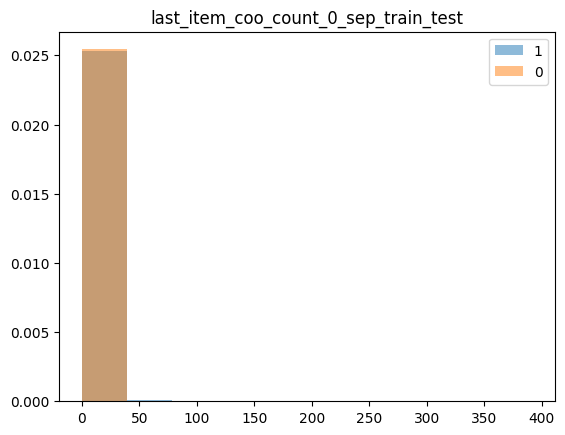

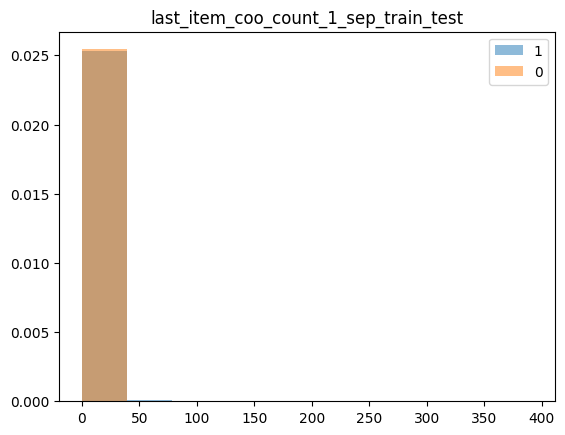

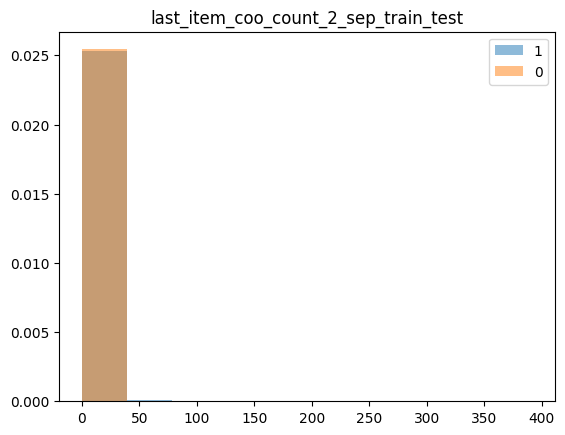

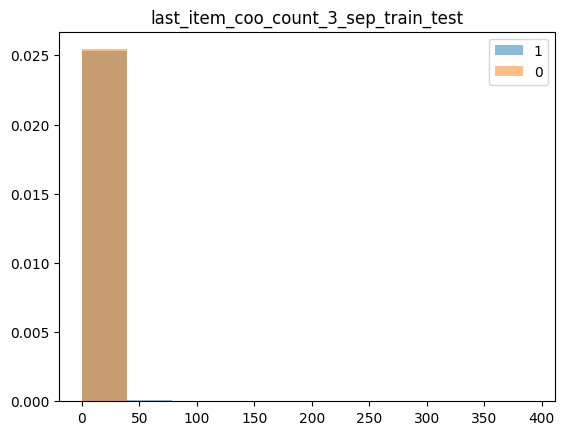

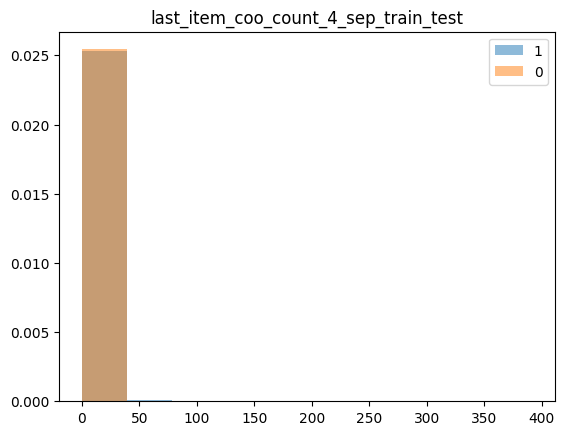

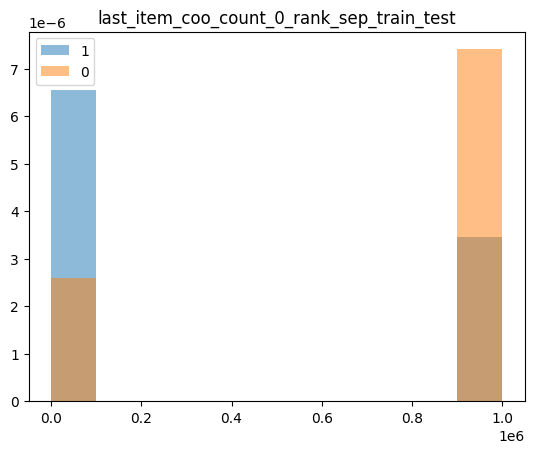

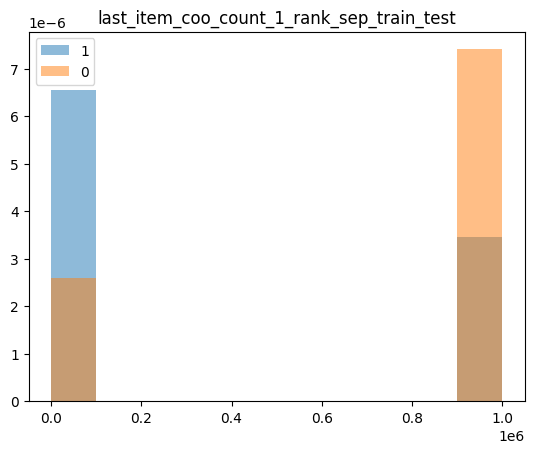

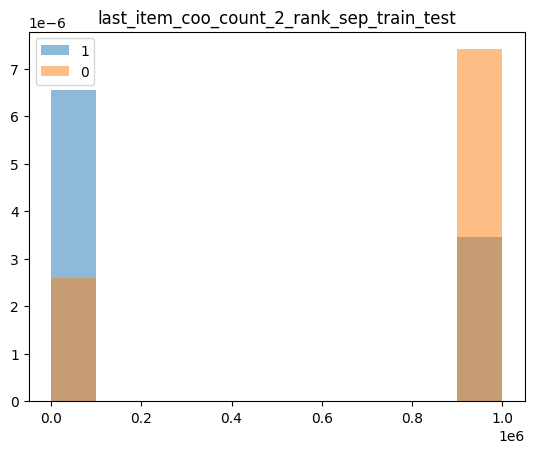

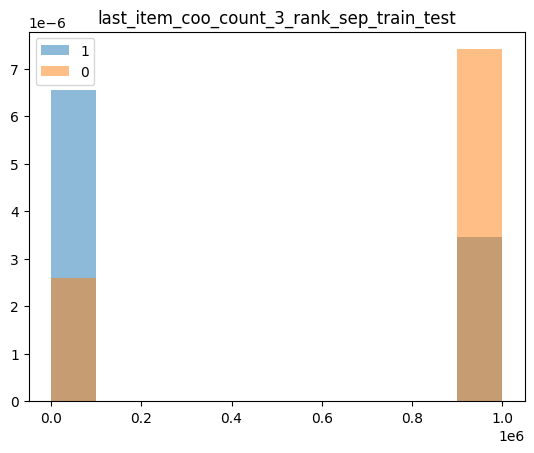

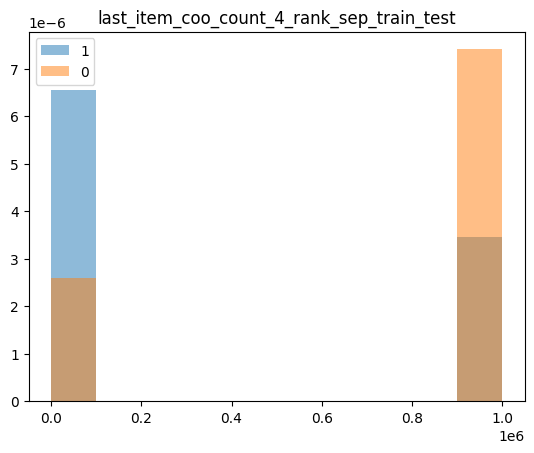

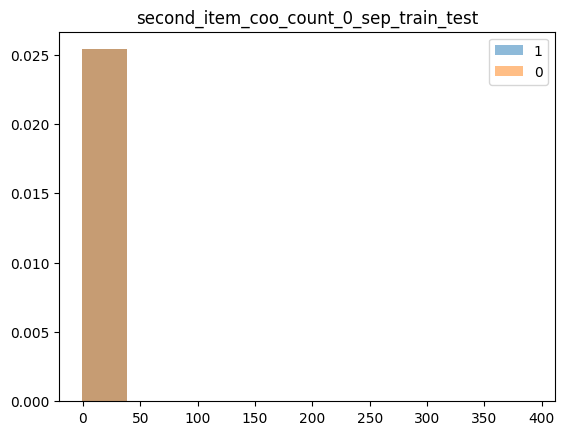

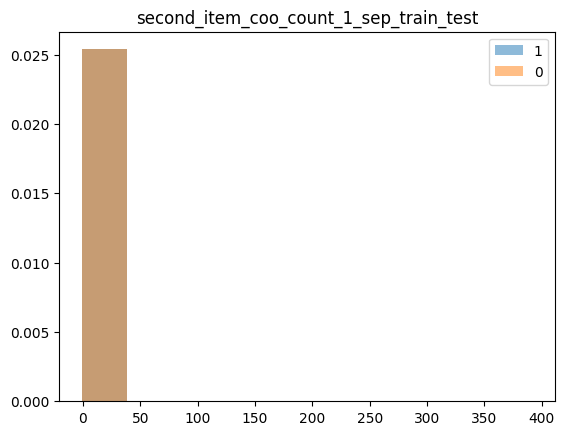

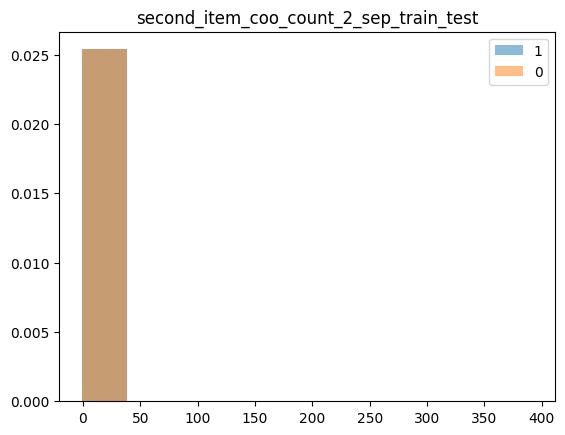

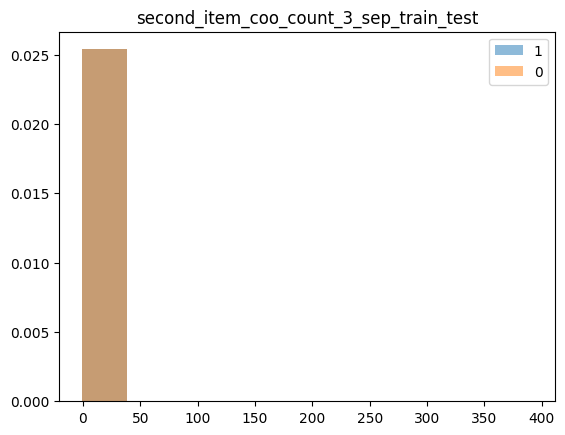

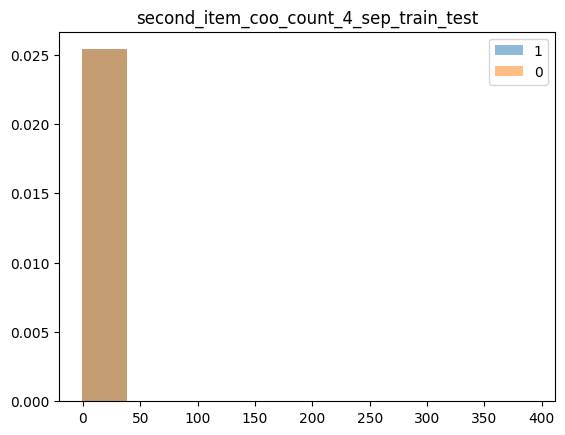

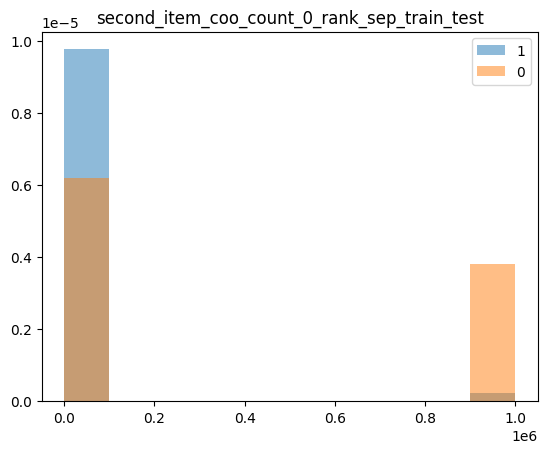

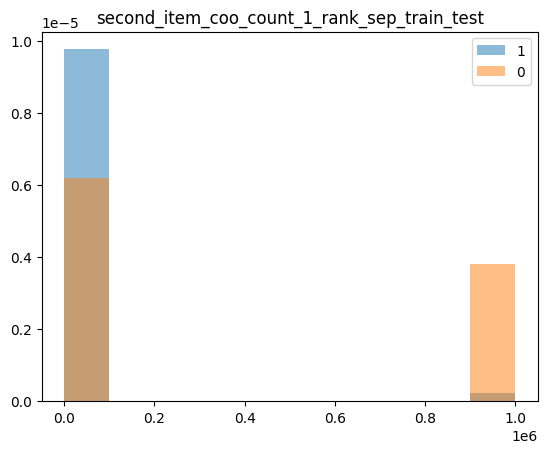

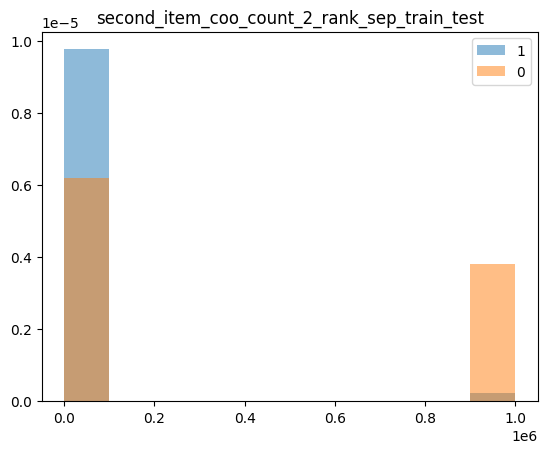

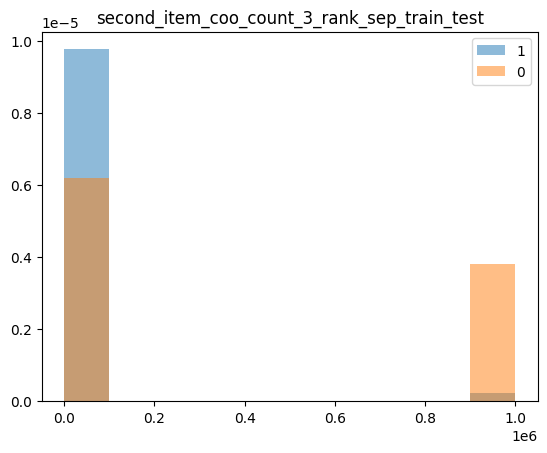

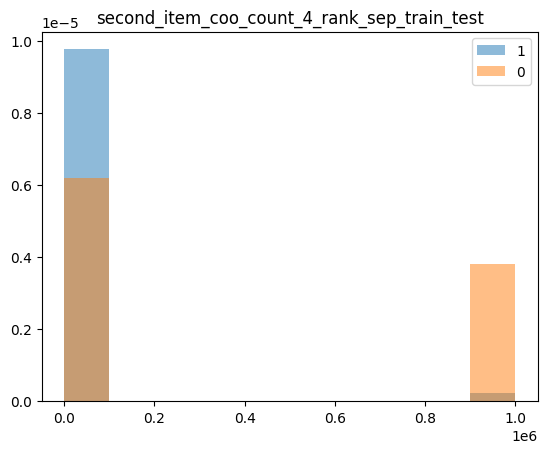

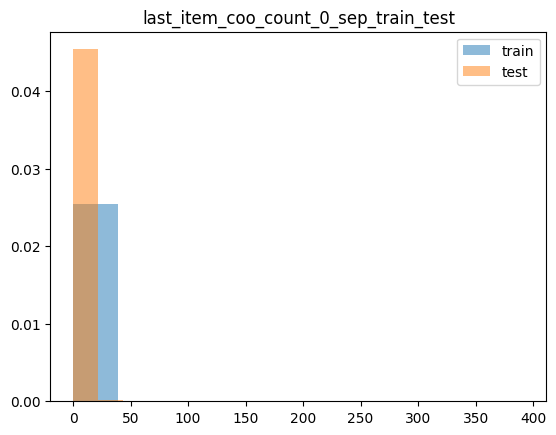

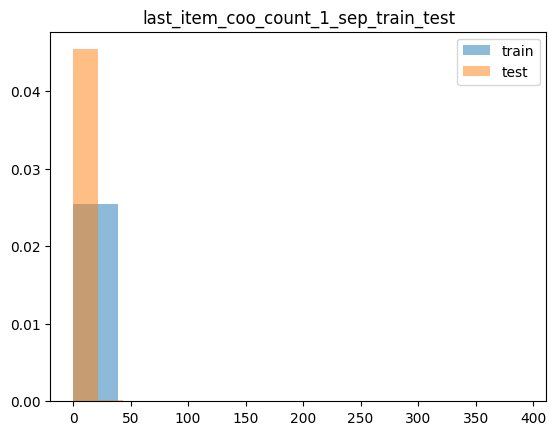

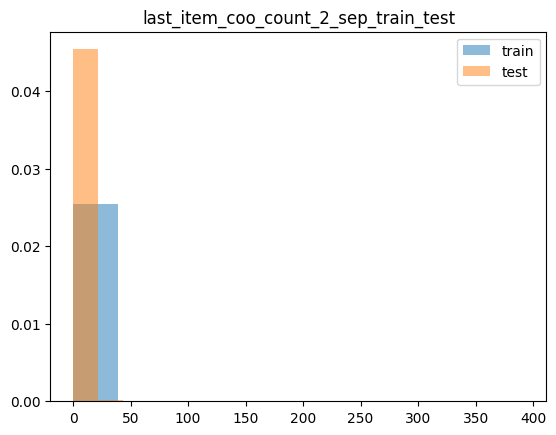

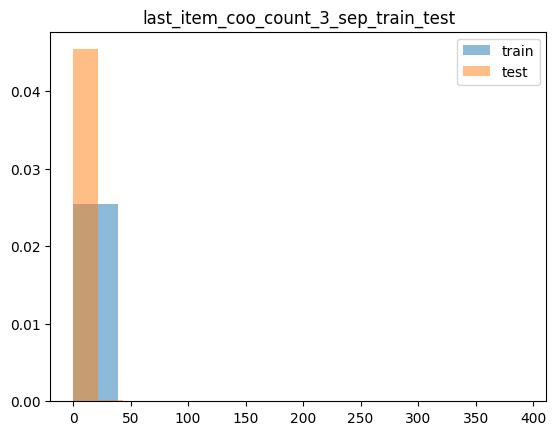

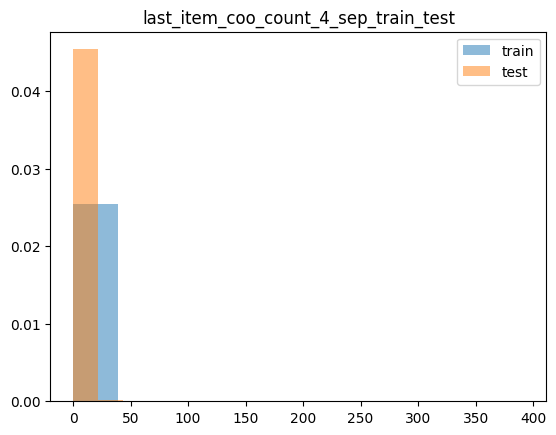

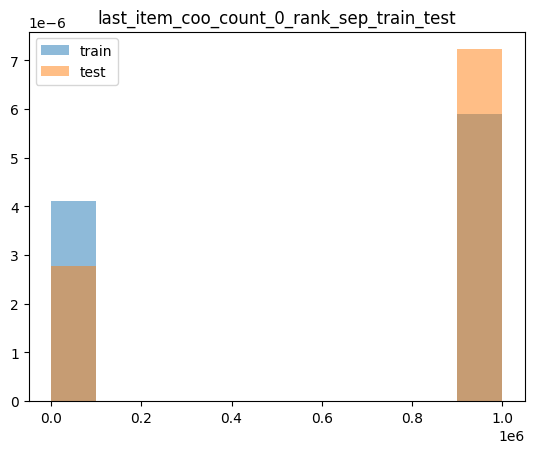

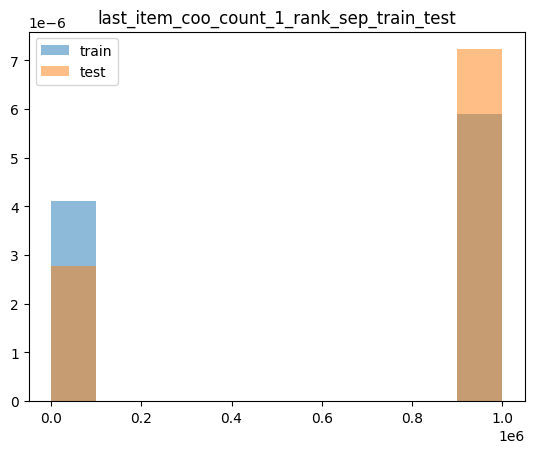

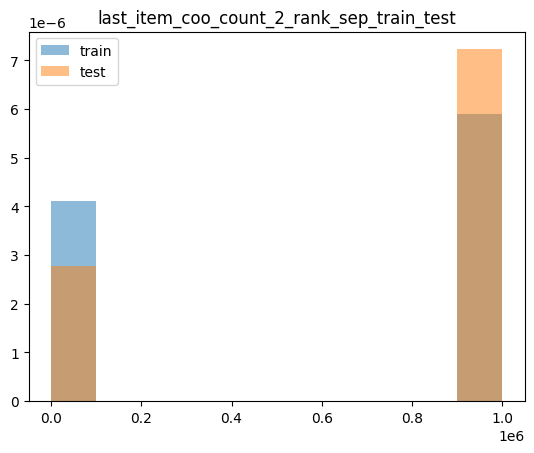

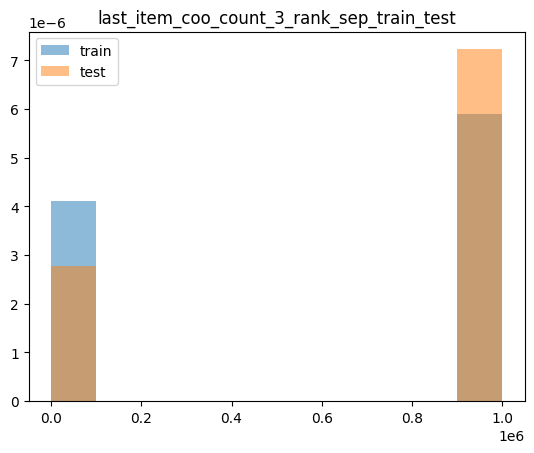

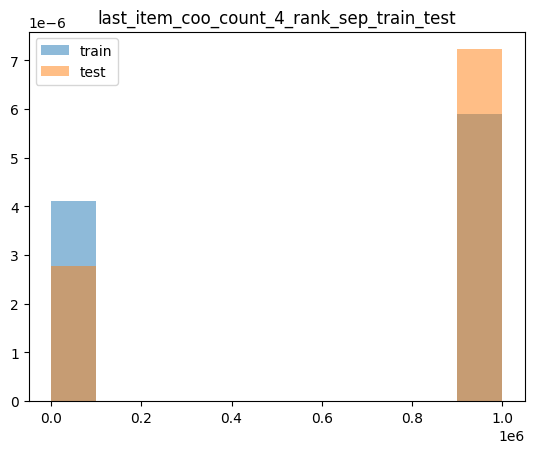

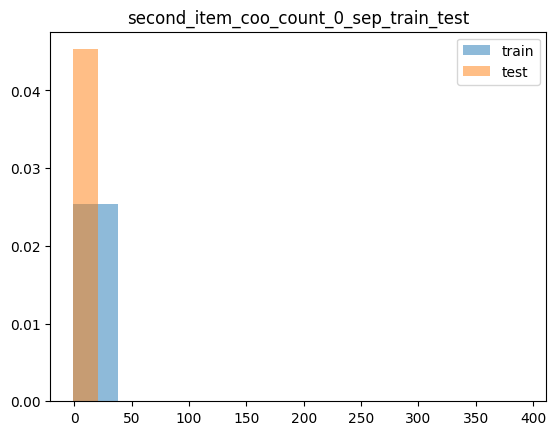

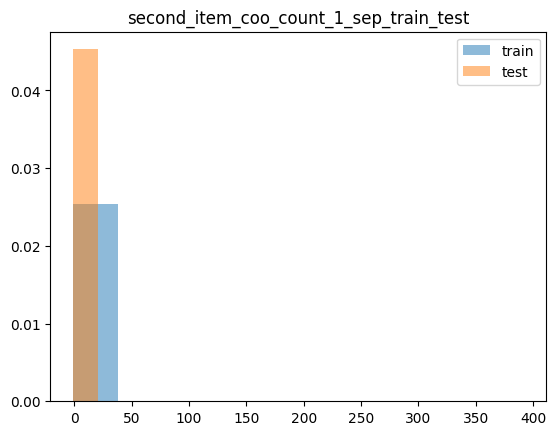

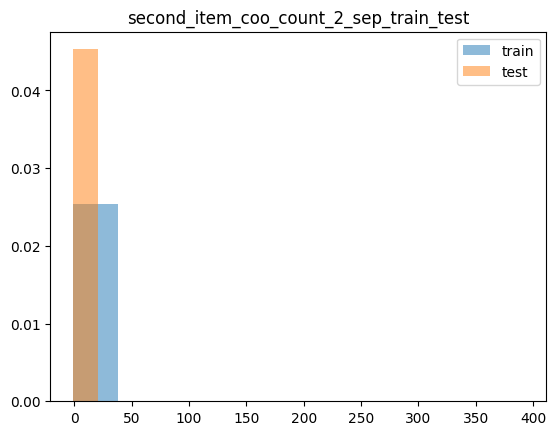

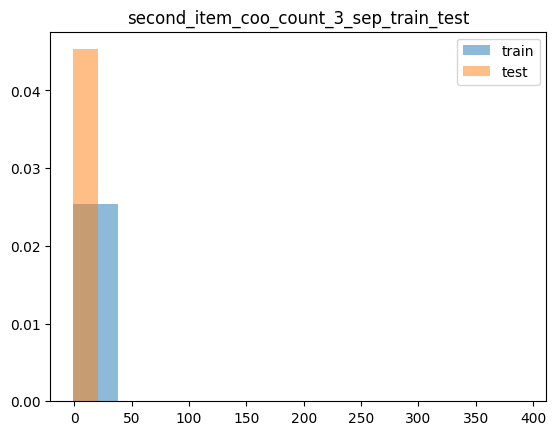

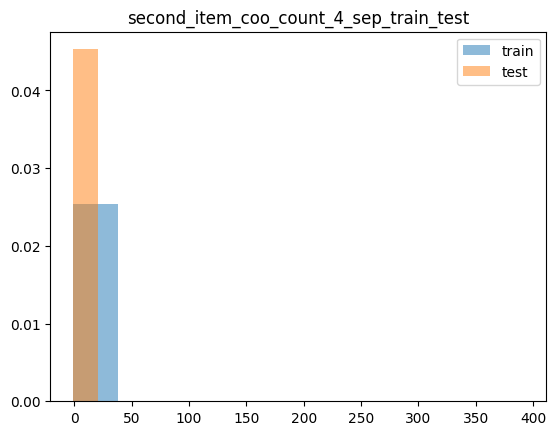

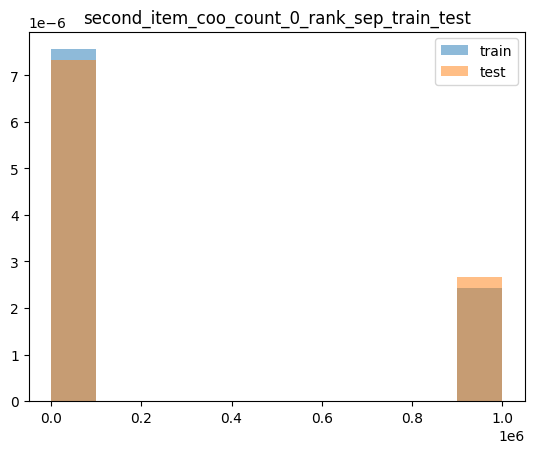

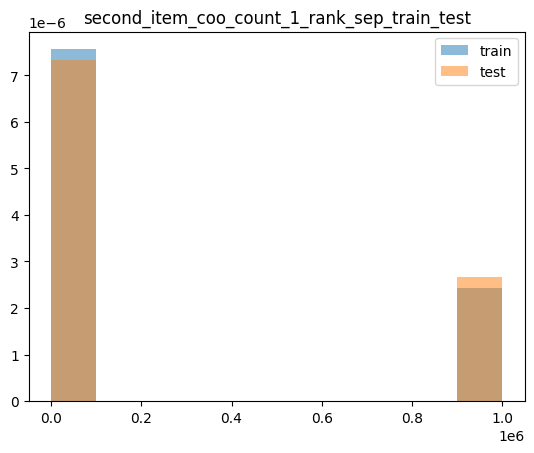

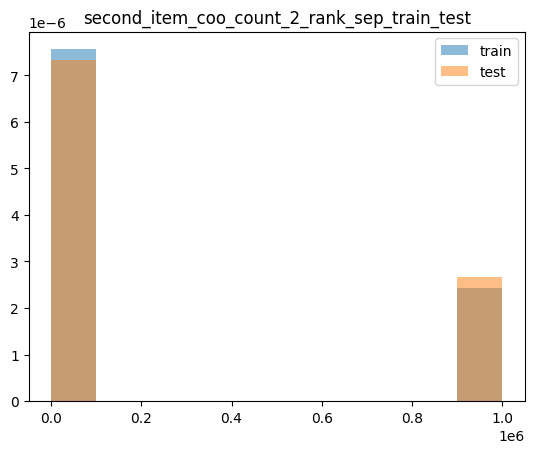

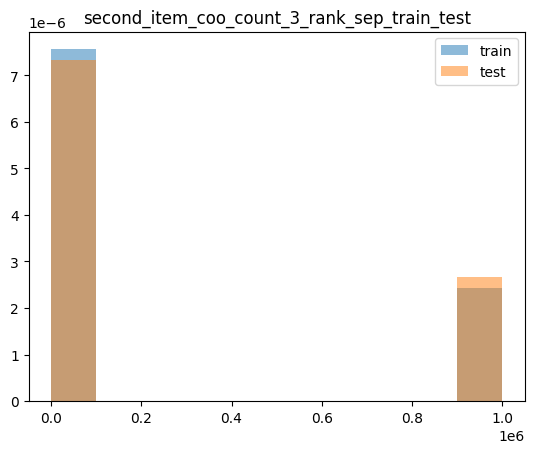

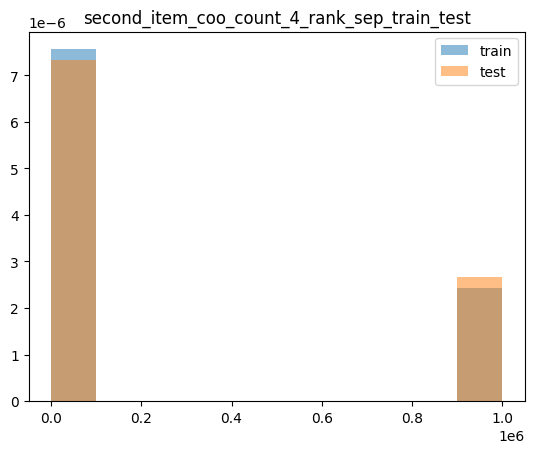

In [93]:
train_df, cols = add_last_item_coo_count_sep_train_test(train_df, train_log_df)
test_df, cols = add_last_item_coo_count_sep_train_test(test_df, test_log_df)

plot_feature_distribution(train_df, cols)
plot_train_test_distribution(train_df, test_df, cols)
sep_train_test_cols += cols

## all_itemのcacheのconcatでOOMになるので、メモリ削減

In [94]:
del_col = ['sml_cd', 'lrg_cd', 'sml_cd_last_item', 'lrg_cd_last_item']
train_df.drop(del_col, axis=1, inplace=True)
test_df.drop(del_col, axis=1, inplace=True)
gc.collect()

143991

## all_itemでcoo これはtrain,test別を作らない(遅い、all_itemだとcountの分布が大きくずれそう)

In [95]:
def add_all_item_coo_count(train_df: pd.DataFrame, test_df: pd.DataFrame, train_test_log_df: pd.DataFrame):

    train_df, test_df, output_cols, return_flag = add_feature_cache(train_df, test_df, sys._getframe().f_code.co_name)
    if return_flag:
        return train_df, test_df, output_cols

    train_test_session_df = train_test_log_df.groupby('session_id')['yad_no'].apply(lambda x: x.values).reset_index()

    counter1 = counter_init()
    counter2 = counter_init()
    counter3 = counter_init()
    counter4 = counter_init()

    for yads in train_test_session_df['yad_no'].values:
        if len(yads) == 1:
            continue
        for i in range(len(yads)-1):
            counter1[yads[i]][yads[i+1]] += 1
            counter1[yads[i+1]][yads[i]] += 1

            counter2[yads[i]][yads[i+1]] += 1

        for i in range(len(yads)-1):
            for j in range(i+1, len(yads)):
                counter3[yads[i]][yads[j]] += 1
                counter3[yads[j]][yads[i]] += 1

                counter4[yads[i]][yads[j]] += 1
    
    # count1を、countではなくrankにする
    counter1_rank = counter_to_rank(counter1)
    counter2_rank = counter_to_rank(counter2)
    counter3_rank = counter_to_rank(counter3)
    counter4_rank = counter_to_rank(counter4)

    output_cols = []

    for c in ['count', 'rank']:
        for agg_col in ['max', 'mean', 'min']:
            for i in range(1, 5):
                output_cols.append(f'all_item_coo_{c}_{i}_{agg_col}')
        
    session_to_yads = dict(zip(train_test_session_df['session_id'], train_test_session_df['yad_no']))

    for target_df in [train_df, test_df]:
        results = []
        for session_id, yad in tqdm(target_df[['session_id', 'yad_no']].values):
            session_yads = session_to_yads[session_id]
            counts = []
            ranks = []
            for session_yad in session_yads:
                counts.append([counter1[session_yad][yad], counter2[session_yad][yad], counter3[session_yad][yad], counter4[session_yad][yad]])
                ranks.append([counter1_rank[session_yad][yad], counter2_rank[session_yad][yad], counter3_rank[session_yad][yad], counter4_rank[session_yad][yad]])

            counts = np.array(counts)
            ranks = np.array(ranks)

            # countの平均
            count_max = counts.max(axis=0)
            count_mean = counts.mean(axis=0)
            count_min = counts.min(axis=0)

            # rankの平均
            rank_max = ranks.max(axis=0)
            rank_mean = ranks.mean(axis=0)
            rank_min = ranks.min(axis=0)

            results.append(np.concatenate([count_max, count_mean, count_min, rank_max, rank_mean, rank_min]))

        target_df[output_cols] = results
        
    # plot_feature_distribution(train_df, output_cols)

    make_feature_cache(train_df, test_df, output_cols, sys._getframe().f_code.co_name)

    return train_df, test_df, output_cols

In [96]:
train_df, test_df, all_item_coo_count_cols = add_all_item_coo_count(train_df, test_df, train_test_log_df)

# sep_train_testでは省メモリ
train_df[all_item_coo_count_cols] = train_df[all_item_coo_count_cols].astype(np.float16)
test_df[all_item_coo_count_cols] = test_df[all_item_coo_count_cols].astype(np.float16)

load: add_all_item_coo_count


## グラフ特徴量

In [97]:
import networkx as nx


In [98]:
def add_graph_feature(target_df, degrees, clusterings, G):
    results = []
    for item1, item2 in tqdm(target_df[['last_item', 'yad_no']].values):
        degree1 = degrees[item1]
        degree2 = degrees[item2]
        degree_diff = degree1 - degree2

        clustering1 = clusterings[item1]
        clustering2 = clusterings[item2]
        clustering_diff = clustering1 - clustering2

        is_connected = nx.has_path(G, item1, item2)
        if is_connected:
            path_length = nx.shortest_path_length(G, item1, item2)
        else:
            path_length = -1

        results.append([degree1, degree2, degree_diff, clustering1, clustering2, clustering_diff, path_length])
    
    output_cols = ['last_item_degree', 'yad_no_degree', 'degree_diff', 'last_item_clustering', 'yad_no_clustering', 'clustering_diff', 'path_length']
    target_df[output_cols] = results

    return target_df, output_cols

def add_graph_feature_train_test(train_df, test_df, train_test_log_df, yado_df):

    train_df, test_df, output_cols, return_flag = add_feature_cache(train_df, test_df, sys._getframe().f_code.co_name)
    if return_flag:
        return train_df, test_df, output_cols
  
    G = nx.Graph()

    G.add_nodes_from(yado_df['yad_no'].tolist())

    sentence_list = train_test_log_df.groupby('session_id')['yad_no'].apply(list).tolist()

    edges = set()
    for items in sentence_list:
        if len(items) == 1:
            continue
        for i in range(len(items)-1):
            edges.add((items[i], items[i+1]))
    edges = list(edges)
    G.add_edges_from(edges)

    degrees = G.degree()
    clusterings = nx.clustering(G)

    train_df, graph_feature_cols = add_graph_feature(train_df, degrees, clusterings, G)
    test_df, _ = add_graph_feature(test_df, degrees, clusterings, G)

    # plot_feature_distribution(train_df, graph_feature_cols)

    make_feature_cache(train_df, test_df, graph_feature_cols, sys._getframe().f_code.co_name)

    return train_df, test_df, graph_feature_cols


In [99]:
train_df, test_df, graph_feature_cols = add_graph_feature_train_test(train_df, test_df, train_test_log_df, yado_df)

load: add_graph_feature_train_test


## graph feature sep train test

In [100]:
def add_graph_feature_sep_train_test(target_df, degrees, clusterings, G):
    results = []
    for item1, item2 in tqdm(target_df[['last_item', 'yad_no']].values):
        degree1 = degrees[item1]
        degree2 = degrees[item2]
        degree_diff = degree1 - degree2

        clustering1 = clusterings[item1]
        clustering2 = clusterings[item2]
        clustering_diff = clustering1 - clustering2

        is_connected = nx.has_path(G, item1, item2)
        if is_connected:
            path_length = nx.shortest_path_length(G, item1, item2)
        else:
            path_length = -1

        results.append([degree1, degree2, degree_diff, clustering1, clustering2, clustering_diff, path_length])
        # results.append([path_length])

    output_cols = ['last_item_degree', 'yad_no_degree', 'degree_diff', 'last_item_clustering', 'yad_no_clustering', 'clustering_diff', 'path_length']
    # output_cols = ['path_length']
    output_cols = [col + '_sep_train_test' for col in output_cols]

    target_df[output_cols] = results
    target_df[output_cols] = target_df[output_cols].astype(np.float16)

    return target_df, output_cols

def add_graph_feature_sep_train_test_main(target_df, target_log_df, yado_df):
  
    G = nx.Graph()

    G.add_nodes_from(yado_df['yad_no'].tolist())

    sentence_list = target_log_df.groupby('session_id')['yad_no'].apply(list).tolist()

    edges = set()
    for items in sentence_list:
        if len(items) == 1:
            continue
        for i in range(len(items)-1):
            edges.add((items[i], items[i+1]))
    edges = list(edges)
    G.add_edges_from(edges)

    degrees = G.degree()
    clusterings = nx.clustering(G)

    target_df, output_cols = add_graph_feature_sep_train_test(target_df, degrees, clusterings, G)

    return target_df, output_cols

100%|██████████| 6637479/6637479 [02:03<00:00, 53572.32it/s]


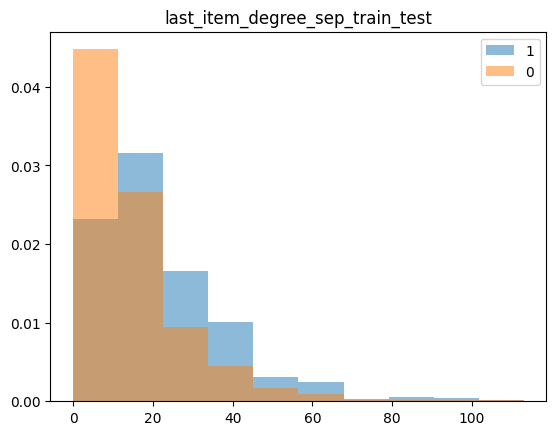

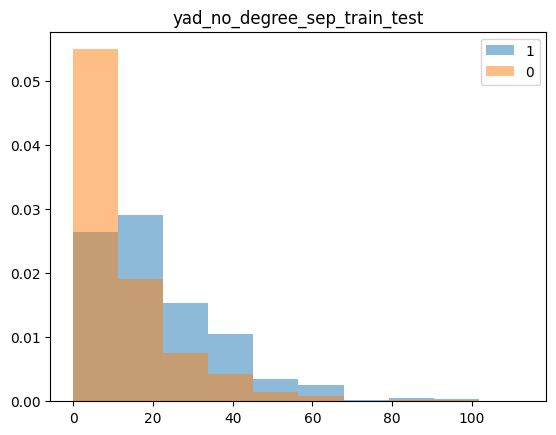

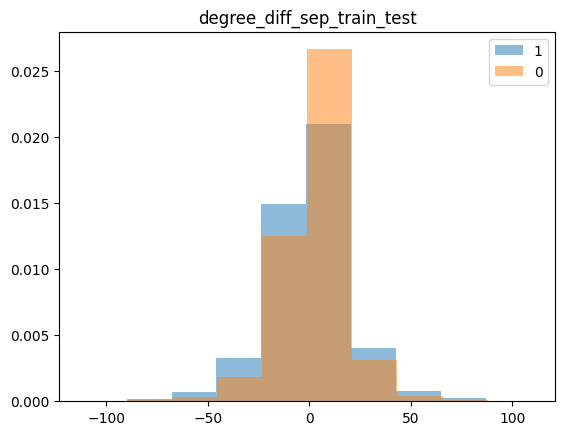

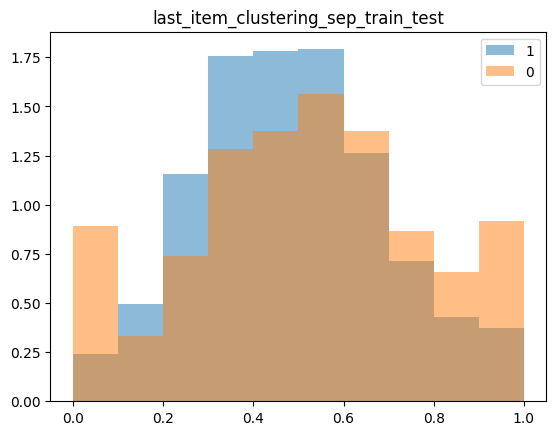

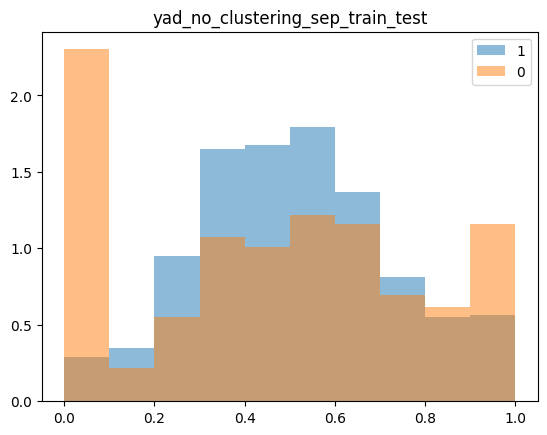

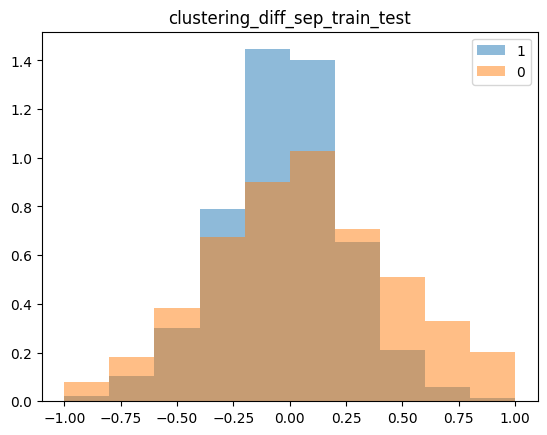

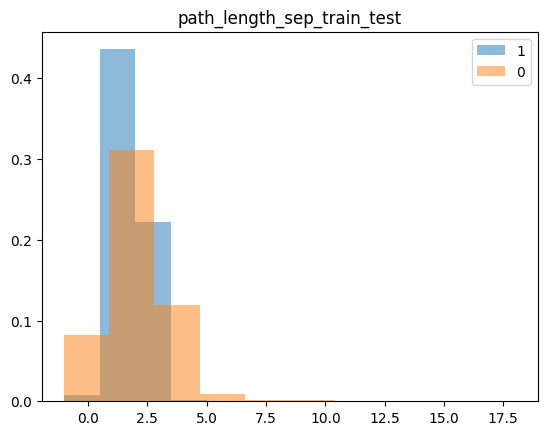

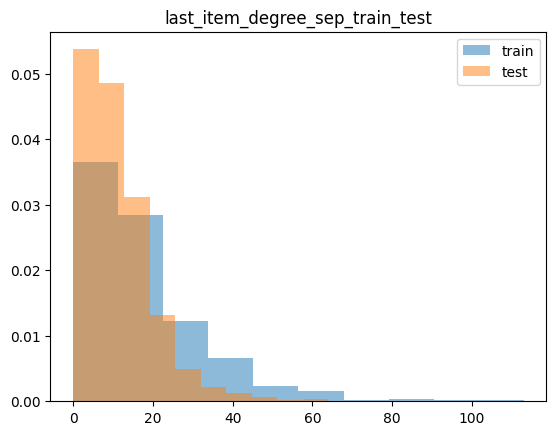

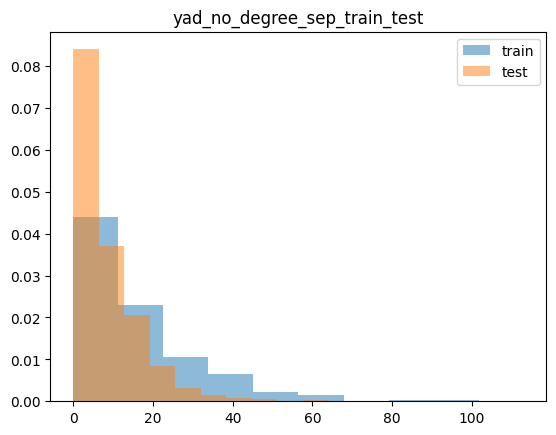

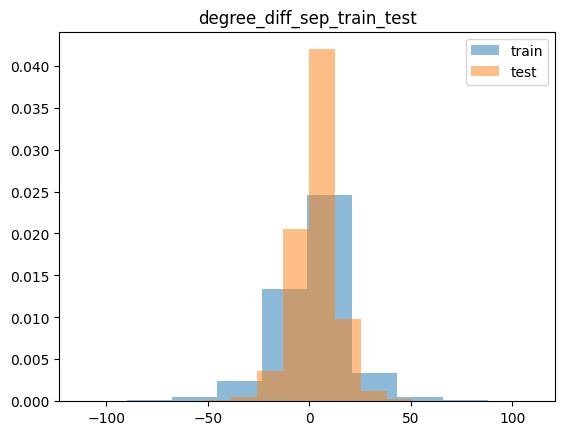

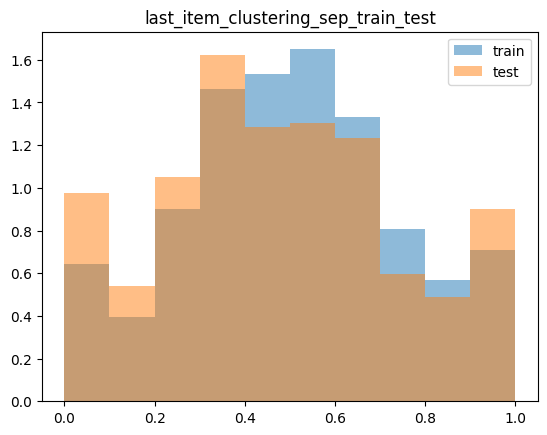

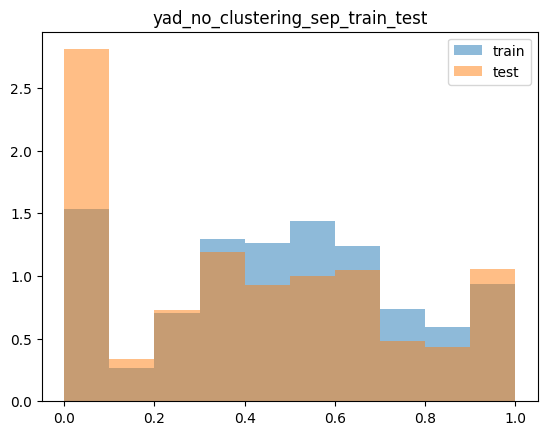

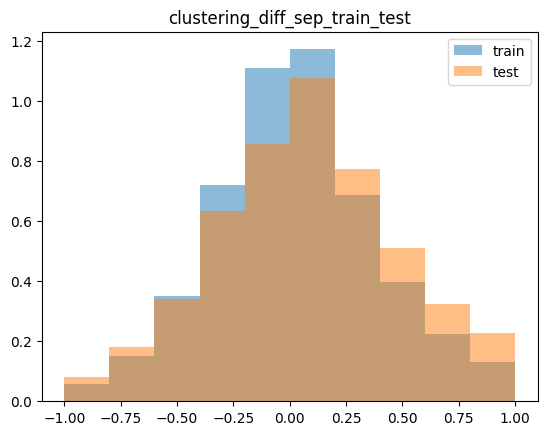

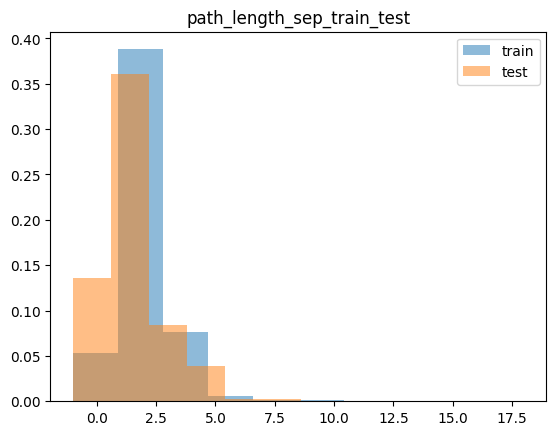

In [101]:
train_df, cols = add_graph_feature_sep_train_test_main(train_df, train_log_df, yado_df)
test_df, cols = add_graph_feature_sep_train_test_main(test_df, test_log_df, yado_df)
plot_feature_distribution(train_df, cols)
plot_train_test_distribution(train_df, test_df, cols)
sep_train_test_cols += cols

In [102]:
"""
https://github.com/unonao/atmacup-15/blob/master/features/create.py
"""
def add_igraph_feature(g):
    pageranks = g.pagerank()
    print("PageRank:", len(pageranks))
    betweenness = g.betweenness()
    print("betweenness:", len(betweenness))
    eigenvector_centrality = g.eigenvector_centrality()
    print("eigenvector_centrality:", len(eigenvector_centrality))
    hub_score = g.hub_score()
    print("hub_score:", len(hub_score))
    authority_score = g.authority_score()
    print("authority_score:", len(authority_score))
    constraint = g.constraint()
    print("constraint:", len(constraint))
    # degree = g.degree()
    # print("degree:", len(degree))
    coreness = g.coreness()
    print("coreness:", len(coreness))
    eccentricity = g.eccentricity()
    print("eccentricity:", len(eccentricity))
    harmonic_centrality = g.harmonic_centrality()
    print("harmonic_centrality:", len(harmonic_centrality))

    node_df = pd.DataFrame(
        {
            "pageranks": pageranks,
            "betweenness": betweenness,
            "eigenvector_centrality": eigenvector_centrality,
            "hub_score": hub_score,
            "authority_score": authority_score,
            "constraint": constraint,
            "coreness": coreness,
            "eccentricity": eccentricity,
            "harmonic_centrality": harmonic_centrality,
        }
    )

    return node_df

In [103]:
"""
import igraph as ig

G = ig.Graph(directed=False)
G.add_vertices(len(yado_df))

edges = [(e1-1, e2-1) for e1, e2 in edges]
G.add_edges(edges)

node_df = add_igraph_feature(G)

igraph_feature_cols = node_df.columns.tolist() 

node_df['yad_no'] = node_df.index + 1

train_df = pd.merge(train_df, node_df, on='yad_no', how='left')
test_df = pd.merge(test_df, node_df, on='yad_no', how='left')

node_df.rename(columns={'yad_no': 'last_item'}, inplace=True)
rename_dict = dict([(col, f'{col}_last_item') for col in igraph_feature_cols])
node_df.rename(columns=rename_dict, inplace=True)

train_df = pd.merge(train_df, node_df, on='last_item', how='left')
test_df = pd.merge(test_df, node_df, on='last_item', how='left')

igraph_feature_cols += [f'{col}_last_item' for col in igraph_feature_cols]
"""

"\nimport igraph as ig\n\nG = ig.Graph(directed=False)\nG.add_vertices(len(yado_df))\n\nedges = [(e1-1, e2-1) for e1, e2 in edges]\nG.add_edges(edges)\n\nnode_df = add_igraph_feature(G)\n\nigraph_feature_cols = node_df.columns.tolist() \n\nnode_df['yad_no'] = node_df.index + 1\n\ntrain_df = pd.merge(train_df, node_df, on='yad_no', how='left')\ntest_df = pd.merge(test_df, node_df, on='yad_no', how='left')\n\nnode_df.rename(columns={'yad_no': 'last_item'}, inplace=True)\nrename_dict = dict([(col, f'{col}_last_item') for col in igraph_feature_cols])\nnode_df.rename(columns=rename_dict, inplace=True)\n\ntrain_df = pd.merge(train_df, node_df, on='last_item', how='left')\ntest_df = pd.merge(test_df, node_df, on='last_item', how='left')\n\nigraph_feature_cols += [f'{col}_last_item' for col in igraph_feature_cols]\n"

## embeddingとの類似度

In [104]:
from myutils.numba_func import calc_cos_sim_numba
def calc_cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [105]:
"""
last_item, second_itemのを別にする
user_factorなくして、
for session_id, yad_no, last_item, second_item in train_df[['session_id', 'yad_no', 'last_item', 'second_item']].values:

に変更する
"""
def add_embedding_sim(train_df, test_df, user_path, item_path, embd_name, dimensions):

    train_df, test_df, output_cols, return_flag = add_feature_cache(train_df, test_df, f'embedding_sim_{embd_name}')
    if return_flag:
        return train_df, test_df, output_cols

    output_cols = [f'cos_sim_{embd_name}']

    user_factors_df = pd.read_pickle(user_path)
    item_factors_df = pd.read_pickle(item_path)

    user_factor_cols = [f'user_factor_{i}' for i in range(dimensions)]
    item_factor_cols = [f'item_factor_{i}' for i in range(dimensions)]

    session2user_factor = dict(zip(user_factors_df['session_id'], user_factors_df[user_factor_cols].values))
    item2item_factor = dict(zip(item_factors_df['yad_no'], item_factors_df[item_factor_cols].values))


    results = []
    for session_id, yad_no in train_df[['session_id', 'yad_no']].values:
        user_factor = session2user_factor[session_id]
        item_factor = item2item_factor[yad_no]

        cos_sim = calc_cos_sim_numba(user_factor, item_factor)

        results.append(cos_sim)
    results = np.array(results).reshape(-1, 1)
    train_df[output_cols] = results

    results = []
    for session_id, yad_no in test_df[['session_id', 'yad_no']].values:
        user_factor = session2user_factor[session_id]
        item_factor = item2item_factor[yad_no]

        cos_sim = calc_cos_sim_numba(user_factor, item_factor)

        results.append(cos_sim)
    results = np.array(results).reshape(-1, 1)
    test_df[output_cols] = results

    # plot_feature_distribution(train_df, output_cols)

    make_feature_cache(train_df, test_df, output_cols, f'embedding_sim_{embd_name}')

    return train_df, test_df, output_cols
    

In [106]:
embedding_cols = []

In [107]:
"""
for category in ['exterior', 'facility', 'food', 'others', 'room']:
    train_df, test_df, cols = add_embedding_sim(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_user_factors_df.pkl', f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}_all_item', 512)
    embedding_cols += cols
"""

"\nfor category in ['exterior', 'facility', 'food', 'others', 'room']:\n    train_df, test_df, cols = add_embedding_sim(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_user_factors_df.pkl', f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}_all_item', 512)\n    embedding_cols += cols\n"

In [108]:

for category in ['exterior', 'facility', 'food', 'others', 'room']:
    train_df, test_df, cols = add_embedding_sim(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_user_factors_last_item_df.pkl', f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}_last_item', 512)
    embedding_cols += cols


load: embedding_sim_image_embedding_exterior_last_item


load: embedding_sim_image_embedding_facility_last_item
load: embedding_sim_image_embedding_food_last_item
load: embedding_sim_image_embedding_others_last_item
load: embedding_sim_image_embedding_room_last_item


In [109]:
%%time
vector_name = 'nmf'

user_suffix = ''
session_user_name = 'all'
train_df, test_df, cols = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', 256)
embedding_cols += cols


user_suffix = 'last_item_'
session_user_name = 'last'
train_df, test_df, cols = add_embedding_sim(train_df, test_df, f'../../datasets/{vector_name}_pkl/{vector_name}_user_factors_{user_suffix}df.pkl', f'../../datasets/{vector_name}_pkl/{vector_name}_item_factors_df.pkl', f'{vector_name}_{session_user_name}_item', 256)
embedding_cols += cols


load: embedding_sim_nmf_all_item


load: embedding_sim_nmf_last_item
CPU times: user 3.15 s, sys: 3.63 s, total: 6.79 s
Wall time: 6.82 s


In [110]:
%%time
train_df, test_df, cols = add_embedding_sim(train_df, test_df, '../../datasets/node2vec_pkl/node2vec_user_factors_df.pkl', '../../datasets/node2vec_pkl/node2vec_item_factors_df.pkl', 'node2vec_all_item', 256)
embedding_cols += cols

load: embedding_sim_node2vec_all_item
CPU times: user 1.58 s, sys: 1.79 s, total: 3.37 s
Wall time: 3.39 s


In [111]:
%%time
train_df, test_df, cols = add_embedding_sim(train_df, test_df, '../../datasets/node2vec_pkl/node2vec_user_factors_last_item_df.pkl', '../../datasets/node2vec_pkl/node2vec_item_factors_df.pkl', 'node2vec_last_item', 256)
embedding_cols += cols

load: embedding_sim_node2vec_last_item
CPU times: user 1.7 s, sys: 1.93 s, total: 3.63 s
Wall time: 3.64 s


In [112]:
%%time
train_df, test_df, cols = add_embedding_sim(train_df, test_df, '../../datasets/prone_pkl/prone_user_factors_df.pkl', '../../datasets/prone_pkl/prone_item_factors_df.pkl', 'prone_all_item', 1024)
embedding_cols += cols

load: embedding_sim_prone_all_item
CPU times: user 1.68 s, sys: 1.99 s, total: 3.67 s
Wall time: 3.69 s


In [113]:
%%time
train_df, test_df, cols = add_embedding_sim(train_df, test_df, '../../datasets/prone_pkl/prone_user_factors_last_item_df.pkl', '../../datasets/prone_pkl/prone_item_factors_df.pkl', 'prone_last_item', 1024)
embedding_cols += cols

load: embedding_sim_prone_last_item
CPU times: user 1.61 s, sys: 2.4 s, total: 4.01 s
Wall time: 4.03 s


In [114]:
%%time
train_df, test_df, cols = add_embedding_sim(train_df, test_df, '../../datasets/prone_directed_pkl/prone_directed_user_factors_df.pkl', '../../datasets/prone_directed_pkl/prone_directed_item_factors_df.pkl', 'prone_directed_all_item', 1024)
embedding_cols += cols

train_df, test_df, cols = add_embedding_sim(train_df, test_df, '../../datasets/prone_directed_pkl/prone_directed_user_factors_last_item_df.pkl', '../../datasets/prone_directed_pkl/prone_directed_item_factors_df.pkl', 'prone_directed_last_item', 1024)
embedding_cols += cols

load: embedding_sim_prone_directed_all_item
load: embedding_sim_prone_directed_last_item
CPU times: user 3.4 s, sys: 5.3 s, total: 8.7 s
Wall time: 8.75 s


## embeddingとの類似度 sep_train_test

In [118]:
def add_embedding_sim_sep_train_test(target_df, user_path, item_path, embd_name, dimensions):

    output_cols = [f'cos_sim_sep_train_test_{embd_name}']

    user_factors_df = pd.read_pickle(user_path)
    item_factors_df = pd.read_pickle(item_path)

    user_factor_cols = [f'user_factor_{i}' for i in range(dimensions)]
    item_factor_cols = [f'item_factor_{i}' for i in range(dimensions)]

    session2user_factor = dict(zip(user_factors_df['session_id'], user_factors_df[user_factor_cols].values))
    item2item_factor = dict(zip(item_factors_df['yad_no'], item_factors_df[item_factor_cols].values))

    results = []
    for session_id, yad_no in target_df[['session_id', 'yad_no']].values:
        user_factor = session2user_factor[session_id]
        item_factor = item2item_factor[yad_no]

        cos_sim = calc_cos_sim_numba(user_factor, item_factor)

        results.append(cos_sim)
    results = np.array(results).reshape(-1, 1)
    target_df[output_cols] = results

    return target_df, output_cols

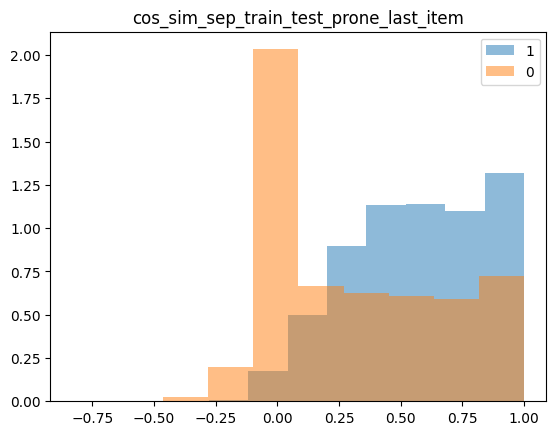

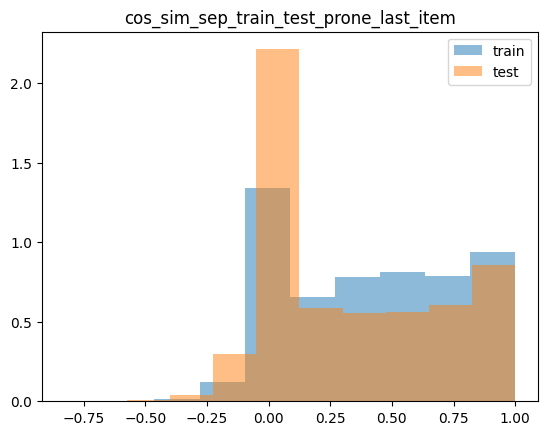

In [119]:
mode = 'train_only'
train_df, cols = add_embedding_sim_sep_train_test(train_df, f'../../datasets/prone_{mode}_pkl/prone_{mode}_user_factors_last_item_df.pkl', f'../../datasets/prone_{mode}_pkl/prone_{mode}_item_factors_df.pkl', 'prone_last_item', 1024)

mode = 'test_only'
test_df, cols = add_embedding_sim_sep_train_test(test_df, f'../../datasets/prone_{mode}_pkl/prone_{mode}_user_factors_last_item_df.pkl', f'../../datasets/prone_{mode}_pkl/prone_{mode}_item_factors_df.pkl', 'prone_last_item', 1024)

plot_feature_distribution(train_df, cols)
plot_train_test_distribution(train_df, test_df, cols)
sep_train_test_cols += cols

In [120]:
gc.collect()

17929

## embeddingとの類似度 second item

In [121]:

def add_embedding_sim_second_item(train_df, test_df, item_path, embd_name, dimensions):

    train_df, test_df, output_cols, return_flag = add_feature_cache(train_df, test_df, f'embedding_sim_second_item_{embd_name}')
    if return_flag:
        return train_df, test_df, output_cols

    output_cols = [f'cos_sim_second_item_{embd_name}']

    item_factors_df = pd.read_pickle(item_path)

    item_factor_cols = [f'item_factor_{i}' for i in range(dimensions)]

    item2item_factor = dict(zip(item_factors_df['yad_no'], item_factors_df[item_factor_cols].values))

    for target_df in [train_df, test_df]:
        results = []
        for yad_no, second_item in target_df[['yad_no', 'second_item']].values:
            if second_item == -1:
                results.append(-1)
                continue
            second_item_factor = item2item_factor[second_item]
            item_factor = item2item_factor[yad_no]

            cos_sim = calc_cos_sim_numba(second_item_factor, item_factor)

            results.append(cos_sim)
        results = np.array(results).reshape(-1, 1)
        target_df[output_cols] = results

    # plot_feature_distribution(train_df, output_cols)

    make_feature_cache(train_df, test_df, output_cols, f'embedding_sim_second_item_{embd_name}')

    return train_df, test_df, output_cols
    

In [122]:
embedding_sim_second_cols = []

In [123]:

for category in ['exterior', 'facility', 'food', 'others', 'room']:
    train_df, test_df, cols = add_embedding_sim_second_item(train_df, test_df, f'../../datasets/image_embedding_pkl/image_embedding_{category}_item_factors_df.pkl', f'image_embedding_{category}', 512)
    embedding_sim_second_cols += cols

load: embedding_sim_second_item_image_embedding_exterior


load: embedding_sim_second_item_image_embedding_facility
load: embedding_sim_second_item_image_embedding_food
load: embedding_sim_second_item_image_embedding_others
load: embedding_sim_second_item_image_embedding_room


In [124]:
train_df, test_df, cols = add_embedding_sim_second_item(train_df, test_df, '../../datasets/node2vec_pkl/node2vec_item_factors_df.pkl', 'node2vec', 256)
embedding_sim_second_cols += cols

load: embedding_sim_second_item_node2vec


In [125]:
train_df, test_df, cols = add_embedding_sim_second_item(train_df, test_df, '../../datasets/prone_pkl/prone_item_factors_df.pkl', 'prone', 1024)
embedding_sim_second_cols += cols

load: embedding_sim_second_item_prone


In [126]:
train_df, test_df, cols = add_embedding_sim_second_item(train_df, test_df, '../../datasets/prone_directed_pkl/prone_directed_item_factors_df.pkl', 'prone_directed', 1024)
embedding_sim_second_cols += cols 

load: embedding_sim_second_item_prone_directed


## 重複確認

second_itemでtail(2)→mergeしていたのが原因

In [127]:
bef_len = len(train_df)
train_df = train_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)
print(bef_len, len(train_df))

bef_len = len(test_df)
test_df = test_df.drop_duplicates(['session_id', 'yad_no']).reset_index(drop=True)
print(bef_len, len(test_df))

11100694 11100694
6637479 6637479


## 特徴量生成

In [128]:
gc.collect()

0

In [129]:
yad_cols

['yad_type',
 'total_room_cnt',
 'wireless_lan_flg',
 'onsen_flg',
 'kd_stn_5min',
 'kd_bch_5min',
 'kd_slp_5min',
 'kd_conv_walk_5min',
 'total_room_cnt_mean@sml_cd',
 'total_room_cnt_max@sml_cd',
 'total_room_cnt_min@sml_cd',
 'total_room_cnt_std@sml_cd',
 'total_room_cnt_median@sml_cd',
 'total_room_cnt_mean@lrg_cd',
 'total_room_cnt_max@lrg_cd',
 'total_room_cnt_min@lrg_cd',
 'total_room_cnt_std@lrg_cd',
 'total_room_cnt_median@lrg_cd',
 'last_item_is_same_sml_cd',
 'last_item_is_same_lrg_cd']

In [130]:
num_cols = []
num_cols += yad_cols
# num_cols += [col for col in train_df.columns if 'rank' in col]
# num_cols += [col for col in train_df.columns if 'count' in col]

num_cols += candidate_rank_cols
num_cols += ['yad_occur_count', 'yad_session_nunique']
num_cols += yad_count_cols
num_cols += user_cols
num_cols += last_item_coo_count_cols

num_cols += embedding_cols

num_cols += yad_last_cols

num_cols += graph_feature_cols
# num_cols += igraph_feature_cols

num_cols += yad_count_last_item_cols

# 1stageでは抜く
num_cols += all_item_coo_count_cols

# num_cols += last_item_set_similarity_cols

num_cols += ['candidate_name_num']

num_cols += yad_area_count_agg_cols

num_cols += yado_area_label_encoding_cols

num_cols += image_category_count_cols

num_cols += embedding_vec_cols

num_cols += yad_second_cols

num_cols += yado_flg_count_cols

num_cols += item_count_in_session_cols

num_cols += embedding_sim_second_cols

# num_cols += yado_flg_agg_area_cols

# num_cols += image_embedding_cluster_cols

# train_df['yad_no_last_item'] = train_df['yad_no'].astype(str) + '_' + train_df['last_item'].astype(str)
# test_df['yad_no_last_item'] = test_df['yad_no'].astype(str) + '_' + test_df['last_item'].astype(str)

"""
yad_no_last_item_to_id_dict = dict([(id, i) for i, id in enumerate(train_df['yad_no_last_item'].unique())])
train_df['yad_no_last_item'] = train_df['yad_no_last_item'].map(yad_no_last_item_to_id_dict)
test_df['yad_no_last_item'] = test_df['yad_no_last_item'].map(yad_no_last_item_to_id_dict)
"""
# CFG.catboost_cat_cols +=  ['yad_no', 'last_item']
# num_cols += ['yad_no', 'last_item']

# num_cols += ['yad_no']

"\nyad_no_last_item_to_id_dict = dict([(id, i) for i, id in enumerate(train_df['yad_no_last_item'].unique())])\ntrain_df['yad_no_last_item'] = train_df['yad_no_last_item'].map(yad_no_last_item_to_id_dict)\ntest_df['yad_no_last_item'] = test_df['yad_no_last_item'].map(yad_no_last_item_to_id_dict)\n"

In [131]:
CFG.outputs_path

'../../outputs/atmacup_16/train_gbdt_2stage_feature_only_sep_train_test_exp002/'

## 保存

In [132]:
import pickle

os.makedirs(CFG.outputs_path + 'feature_pkl/', exist_ok=True)

train_df.to_pickle(CFG.outputs_path + 'feature_pkl/train_df.pkl')
test_df.to_pickle(CFG.outputs_path + 'feature_pkl/test_df.pkl')

# num_colsをpickleで保存
pickle.dump(num_cols, open(CFG.outputs_path + 'feature_pkl/num_cols.pkl', 'wb'))


In [133]:
pickle.dump(sep_train_test_cols, open(CFG.outputs_path + 'feature_pkl/sep_train_test_cols.pkl', 'wb'))


In [134]:
sep_train_test_cols

['yad_occur_count_sep_train_test',
 'yad_occur_rank_sml_cd_sep_train_test',
 'yad_occur_rank_wid_cd_sep_train_test',
 'yad_occur_rank_ken_cd_sep_train_test',
 'yad_occur_rank_lrg_cd_sep_train_test',
 'yad_occur_count_last_item_sep_train_test',
 'yad_session_nunique_last_item_sep_train_test',
 'yad_occur_rank_last_item_sep_train_test_sml_cd',
 'yad_occur_rank_last_item_sep_train_test_wid_cd',
 'yad_occur_rank_last_item_sep_train_test_ken_cd',
 'yad_occur_rank_last_item_sep_train_test_lrg_cd',
 'last_item_coo_count_0_sep_train_test',
 'last_item_coo_count_1_sep_train_test',
 'last_item_coo_count_2_sep_train_test',
 'last_item_coo_count_3_sep_train_test',
 'last_item_coo_count_4_sep_train_test',
 'last_item_coo_count_0_rank_sep_train_test',
 'last_item_coo_count_1_rank_sep_train_test',
 'last_item_coo_count_2_rank_sep_train_test',
 'last_item_coo_count_3_rank_sep_train_test',
 'last_item_coo_count_4_rank_sep_train_test',
 'second_item_coo_count_0_sep_train_test',
 'second_item_coo_count_1